# **Seq2Event: Notebook 2: Modelling**

In [245]:
import numpy as np; import pandas as pd; import sklearn as sk; import matplotlib.pyplot as plt; import seaborn as sns; import os
import random; from scipy import stats; from sklearn import preprocessing; from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy.lib.recfunctions as rfn; import statsmodels.api as sm; from statsmodels.graphics.regressionplots import abline_plot
import numpy as np; from sklearn.linear_model import LinearRegression; from sklearn.metrics import mean_squared_error, r2_score
import math; from sklearn import linear_model
from numpy import linalg; from scipy import stats; import cv2; import math; from matplotlib import cm; from matplotlib import colors
import matplotlib as mpl; from matplotlib.ticker import (AutoMinorLocator, MultipleLocator); import scipy.stats as st; import scipy as sp
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import os; print(os.getcwd())
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib import cm
import matplotlib.patches as mpatches
from torchvision.datasets.utils import download_url
from zipfile import ZipFile

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print("CPU-only runtime")
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

import torch
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from numpy import linalg
from scipy import stats
import cv2
import math
from tqdm import tqdm
from matplotlib import cm
from matplotlib import colors
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import scipy.stats as st
import torch.optim as optim
torch.set_printoptions(precision=4,sci_mode=False)
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import random
import sys
import io
!pip install py7zr
import py7zr
!pip install gdown

/content
Tue Aug  9 19:34:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    40W / 250W |    737MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               

In [246]:
################################################################################################
# Initialise Google Drive (in order to save model states later; if not desired, can delete this and comment out state saves later as required)
################################################################################################
from google.colab import drive    # optional - only used to save the results of process to Google Drive...
drive.mount('/content/gdrive')    # ...comment this out if this is not needed.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [247]:
################################################################################################
# Device to use for modelling
################################################################################################
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#Set up data

In [248]:
################################################################################################
# 0) Download data
################################################################################################

################################################################################################
# 0a) Download data from step 1 "data import" notebook
################################################################################################
!gdown 1-QPhkhFGJCjL_Bc_zIGCYkLGsB7TZAPu    #Google Drive open access sharing link
df = pd.read_pickle("/content/WyScout_open_data_df_notebook1_step2.pkl")
df = df.reset_index()

################################################################################################
# 0b) Download team list with train/val/test allocation
################################################################################################
!gdown 1Jf3c4q6oXL5OzshFaTQ9lwQdhpzEJ_Kc    #Google Drive open access sharing link
teams_list = pd.read_csv("/content/soccer_teams_to_import.csv")

Downloading...
From: https://drive.google.com/uc?id=1-QPhkhFGJCjL_Bc_zIGCYkLGsB7TZAPu
To: /content/WyScout_open_data_df_notebook1_step2.pkl
100% 293M/293M [00:00<00:00, 304MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jf3c4q6oXL5OzshFaTQ9lwQdhpzEJ_Kc
To: /content/soccer_teams_to_import.csv
100% 1.36k/1.36k [00:00<00:00, 1.62MB/s]


In [249]:
################################################################################################
# 1) Choose matches according to teams_list and filter dataframe
################################################################################################

################################################################################################
# 1b) filter dataframe: keep only matches of the teams of interest
################################################################################################
idx = np.repeat(False,len(df))
for i in range(len(teams_list)):
  idx0 = np.logical_and(df['comp'] == teams_list.loc[i,'Comp'],df['TID'] == teams_list.loc[i,'wyId'])
  idx = np.logical_or(idx,idx0)
df = df.loc[idx,:]

################################################################################################
# 1c) choose a pool of matches from each team (s.t. we have just the right number i.e. number of trn + val + tst)
################################################################################################
idx = np.repeat(False,len(df))
np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempmatches = np.unique(df.loc[df["TID"]==tempteam['wyId'],"MID"])
  num_matches_to_choose = tempteam['trn'] + tempteam['val'] + tempteam['tst']
  matches_to_keep = np.random.choice(tempmatches,num_matches_to_choose,replace=False) # random (seeded) choice of matches to choose
  idx0 = np.logical_and(df['comp'] == tempteam['Comp'],df['TID'] == tempteam['wyId'])
  idx1 = np.logical_and(idx0,np.isin(df['MID'],matches_to_keep))
  idx = np.logical_or(idx,idx1)


################################################################################################
# 1d) filter dataframe further now we have chosen the matches we want
################################################################################################
df = df.loc[idx,:]
df = df.sort_values(by=['TID','MID','index'])
df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

################################################################################################
# 1e) now assign specific matches from teams_list against each team
################################################################################################
#(training/validation), and (test)
teams_list['trn_MIDs'], teams_list['val_MIDs'], teams_list['tst_MIDs'] = None, None, None
teams_list['n_trn'], teams_list['n_val'], teams_list['n_tst'] = 0, 0, 0
teams_list['trn_MIDs'], teams_list['val_MIDs'], teams_list['tst_MIDs'] = teams_list['trn_MIDs'].astype(object), teams_list['val_MIDs'].astype(object), teams_list['tst_MIDs'].astype(object)

np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempteam_allmatches = np.unique(df.loc[df["TID"] == tempteam["wyId"],"MID"])
  np.random.shuffle(tempteam_allmatches)                       # perturbation: shuffle all of this team's MIDs in place
  teams_list['trn_MIDs'][i] = tempteam_allmatches[:tempteam["trn"]]
  teams_list['val_MIDs'][i] = tempteam_allmatches[tempteam["trn"]:(tempteam["trn"]+tempteam["val"])]
  teams_list['tst_MIDs'][i] = tempteam_allmatches[(tempteam["trn"]+tempteam["val"]):]
  teams_list['n_trn'][i] = np.sum(np.isin(df["MID"],teams_list['trn_MIDs'][i]))
  teams_list['n_val'][i] = np.sum(np.isin(df["MID"],teams_list['val_MIDs'][i]))
  teams_list['n_tst'][i] = np.sum(np.isin(df["MID"],teams_list['tst_MIDs'][i]))

teams_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to b

Comp  Pos                      Team  trn  val  tst   wyId  \
0    EN    1           Manchester City    3    0    0   1625   
1    EN    2         Manchester United    0    0    3   1611   
2    EN   10          Newcastle United    0    0    3   1613   
3    EN   11            Crystal Palace    3    1    0   1628   
4    EN   19                Stoke City    0    0    3   1639   
5    EN   20      West Bromwich Albion    3    0    0   1627   
6    DE    1             Bayern Munich    3    0    0   2444   
7    DE    2                Schalke 04    0    0    3   2449   
8    DE    9  Borussia Mönchengladbach    0    0    3   2454   
9    DE   10                Hertha BSC    3    1    0   2457   
10   DE   17              Hamburger SV    0    0    3   2450   
11   DE   18                1. FC Köln    3    0    0   2463   
12   ES    1                 Barcelona    3    0    0    676   
13   ES    2           Atlético Madrid    0    0    3    679   
14   ES   10                    Girona    0    0    3    756   
15   ES   11                  Espanyol    3    0    0    691   
16   ES   19                Las Palmas    0    0    3    714   
17   ES   20                    Málaga    3    1    0    683   
18   IT    1                  Juventus    3    1    0   3159   
19   IT    2                    Napoli    0    0    3   3187   
20   IT   10                 Sampdoria    0    0    3   3164   
21   IT   11                  Sassuolo    3    0    0   3315   
22   IT   19             Hellas Verona    0    0    3   3194   
23   IT   20                 Benevento    3    0    0   3219   
24   FR    1       Paris Saint-Germain    3    1    0   3767   
25   FR    2                    Monaco    0    0    3  19830   
26   FR   10               Montpellier    0    0    3   3787   
27   FR   11                     Dijon    3    0    0   3804   
28   FR   19                    Troyes    0    0    3   3795   
29   FR   20                      Metz    3    0    0   3777   
30   WC    C                    France    3    1    0   4418   
31   WC    F                   Croatia    0    0    3   9598   
32   WC  R16                  Colombia    3    0    0  12430   
33   WC  R16                   Denmark    0    0    3   7712   
34   WC    3               South Korea    3    0    0  14855   
35   WC    3                   Tunisia    0    0    3  16276   
36   WC    4                    Panama    3    0    0  17929   
37   WC    4                    Poland    0    0    3  13869   
38   EU    F                  Portugal    3    0    0   9905   
39   EU   SF                     Wales    0    0    3  10682   
40   EU  R16                   Hungary    3    1    0  10451   
41   EU  R16               Switzerland    0    0    3   6697   
42   EU  R16       Republic of Ireland    3    0    0   8274   
43   EU    3                   Albania    0    0    3   8731   
44   EU    4            Czech Republic    3    0    0  11555   
45   EU    4                    Sweden    0    0    3   7047   

                       trn_MIDs   val_MIDs                     tst_MIDs  \
0   [2499781, 2499822, 2499841]         []                           []   
1                            []         []  [2499914, 2499898, 2500001]   
2                            []         []  [2499964, 2500027, 2499823]   
3   [2499741, 2499961, 2499774]  [2499894]                           []   
4                            []         []  [2499765, 2499805, 2499920]   
5   [2500019, 2499792, 2499854]         []                           []   
6   [2517018, 2516982, 2516997]         []                           []   
7                            []         []  [2517011, 2516770, 2516797]   
8                            []         []  [2516851, 2516778, 2516814]   
9   [2516967, 2516840, 2516813]  [2516920]                           []   
10                           []         []  [2516887, 2516980, 2516962]   
11  [2516762, 2516831, 2516844]         []                           []   
12  [2565704, 25658

In [250]:
################################################################################################
# 2) Insert match buffer after each match
################################################################################################

################################################################################################
# 2a) make a generic buffer row (we'll need to update the '123' fields however before adding in the for loop)
################################################################################################
paddingrow = df.iloc[-1,:]
paddingrow = pd.DataFrame(paddingrow).T
paddingrow["comp"] = "na"       #need to update each time padding is added
paddingrow["TID"] = 123         #need to update each time padding is added
paddingrow["MID"] = 123         #need to update each time padding is added
paddingrow["index"] = 1000000000
paddingrow["PID"] = 1000000000
paddingrow["act"] = "@"
paddingrow["T"] = 0.5           #df["T"].mean()
paddingrow["deltaT"] = 0.5      #df["deltaT"].mean()
paddingrow["x"] = 0.5          #df["x"].mean()
paddingrow["y"] = 0.5          #df["y"].mean()
paddingrow["s"] = 0.2           #df["s"].mean() 
paddingrow["scrad"] = 0.5       #df["scrad"].mean()
paddingrow["deltax"] = 0.5     #df["deltax"].mean() 
paddingrow["deltay"] = 0.5     #df["deltay"].mean()
paddingrow["sg"] = 0.57         #df["sg"].mean()
paddingrow["thetag"] = 0.74     #df["thetag"].mean()
num_paddingrows=1
paddingrows = paddingrow.iloc[np.repeat(0,num_paddingrows),:]

################################################################################################
# 2b) make a generic buffer row (we'll need to update the '123' fields however before adding in the for loop)
################################################################################################
def insert_rows(idx, df, df_to_insert):  # convenience function to insert a row
    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]
    df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
    return df

################################################################################################
# 2c) find out where we need to insert this padding/buffers
################################################################################################
bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #the idxn indicates the LAST row of a match (MID)

################################################################################################
# 2d) insert the buffers
################################################################################################
for i in tqdm(range(0,len(bufidxns))):   # insert the padding/buffers
  # print(i)
  bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #recompute each time...
  bufidxn = bufidxns[i]
  paddingrows["comp"] = df.loc[bufidxn,"comp"]
  paddingrows["TID"] = df.loc[bufidxn,"TID"]
  paddingrows["MID"] = df.loc[bufidxn,"MID"]
  df = insert_rows(bufidxn+1,df,paddingrows)

df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

##########################################################################################
# 2e) minor tidy-up: rearrange columns
##########################################################################################
df = df.loc[:,['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']]

100%|██████████| 144/144 [00:07<00:00, 19.61it/s]


n idx_all 101895
n idx_trn 48463
n idx_val 4932
n idx_tst 48500
n idx_dmo 1332


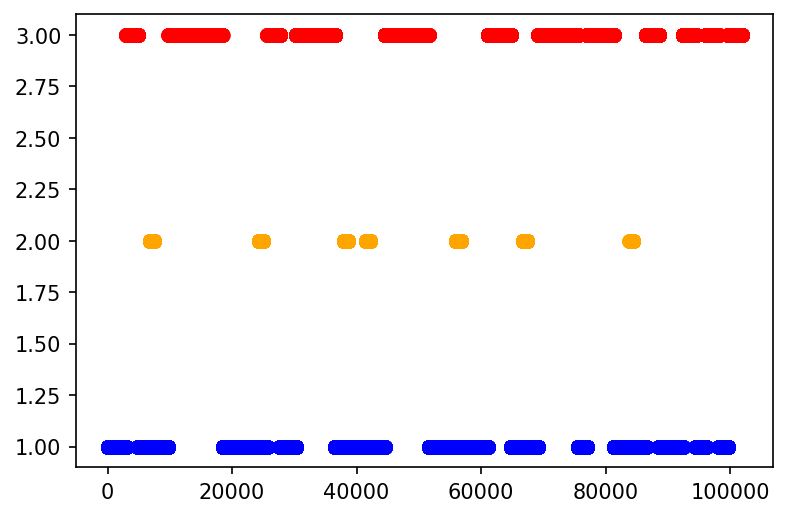

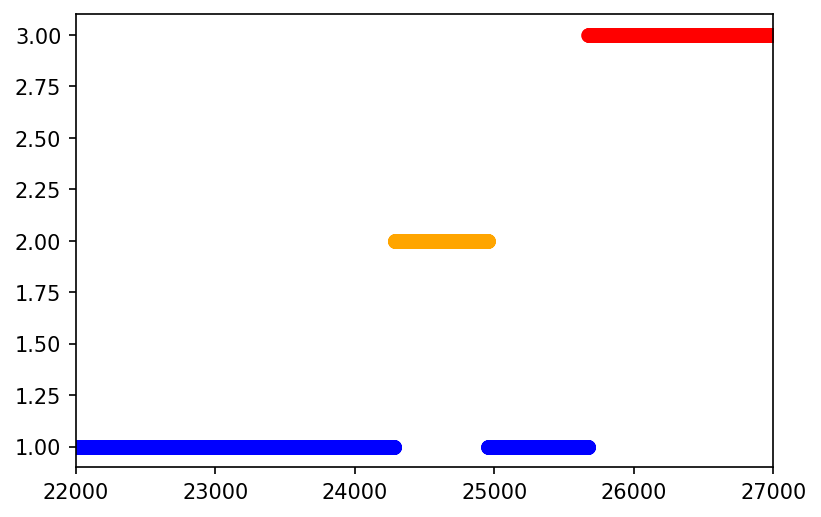

idx_trn:
 ['1694409-11555' '1694410-11555' '1694413-11555' '1694417-8274'
 '1694418-8274' '1694421-9905' '1694422-10451' '1694423-9905'
 '1694424-10451' '1694429-8274' '1694431-10451' '1694440-9905'
 '2057968-4418' '2057985-14855' '2057987-14855' '2057988-14855'
 '2057990-17929' '2057993-17929' '2057995-17929' '2057998-12430'
 '2058001-12430' '2058009-12430' '2058014-4418' '2058017-4418'
 '2499741-1628' '2499774-1628' '2499781-1625' '2499792-1627'
 '2499822-1625' '2499841-1625' '2499854-1627' '2499961-1628'
 '2500019-1627' '2500699-3804' '2500859-3777' '2500904-3804'
 '2500947-3804' '2500952-3767' '2500972-3767' '2500983-3767'
 '2501001-3777' '2501060-3777' '2516762-2463' '2516813-2457'
 '2516831-2463' '2516840-2457' '2516844-2463' '2516967-2457'
 '2516982-2444' '2516997-2444' '2517018-2444' '2565560-691' '2565576-683'
 '2565681-676' '2565702-683' '2565704-676' '2565734-683' '2565786-691'
 '2565820-676' '2565910-691' '2576010-3219' '2576023-3315' '2576102-3315'
 '2576154-3159' '2576163

In [251]:
##########################################################################################
# 3) Define data loaders
##########################################################################################

##########################################################################################
# 3a) Specify indices for whole, trnval, tst, dmo 
##########################################################################################
np.random.seed(123)
##########################################################################################
# 3a)i)   whole set -> idx_all (100% of total)
##########################################################################################
idx_all = np.repeat(True,len(df))
print("n idx_all",np.sum(idx_all))

##########################################################################################
# 3a)ii)  trn set   -> idx_trn
##########################################################################################
idx_trn = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['trn_MIDs']))
  idx_trn = np.logical_or(idx_trn,idx0)
print("n idx_trn",np.sum(idx_trn))

##########################################################################################
# 3a)iii) val set   -> idx_val
##########################################################################################
idx_val = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['val_MIDs']))
  idx_val = np.logical_or(idx_val,idx0)
print("n idx_val",np.sum(idx_val))

##########################################################################################
# 3a)iv)  tst set   -> idx_tst
##########################################################################################
idx_tst = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['tst_MIDs']))
  idx_tst = np.logical_or(idx_tst,idx0)
print("n idx_tst",np.sum(idx_tst))

##########################################################################################
# 3a)v)   dmo set   -> idx_dmo
##########################################################################################
# 2 matches in demo set
# MID 2058017, France - Croatia, 4 - 2, 15 July 2018
# MID 2576028, Udinese - Sampdoria, 4 - 0, 30 Sept 2017
idx_dmo = np.isin(df["MID"],np.array([2058017,2576028]))
print("n idx_dmo",np.sum(idx_dmo))

##########################################################################################
# 3a)vi)  Illustrative plots
##########################################################################################
fig, ax = plt.subplots()
ax.scatter(range(len(idx_trn)),idx_trn,color="blue")
ax.scatter(range(len(idx_val)),idx_val*2,color="orange")
ax.scatter(range(len(idx_tst)),idx_tst*3,color="red")
ax.set_ylim(.9,3.1)
plt.show()

fig, ax = plt.subplots()
ax.scatter(range(len(idx_trn)),idx_trn,color="blue")
ax.scatter(range(len(idx_val)),idx_val*2,color="orange")
ax.scatter(range(len(idx_tst)),idx_tst*3,color="red")
ax.set_ylim(.9,3.1)
ax.set_xlim(22000,27000)
plt.show()

##########################################################################################
# 3a)vii) summary of MIDs used
##########################################################################################
print("idx_trn:\n", np.unique(df.loc[idx_trn,"MID"].map(str) + "-" + df.loc[idx_trn,"TID"].map(str)))
print("idx_val:\n", np.unique(df.loc[idx_val,"MID"].map(str) + "-" + df.loc[idx_val,"TID"].map(str)))
print("idx_tst:\n", np.unique(df.loc[idx_tst,"MID"].map(str) + "-" + df.loc[idx_tst,"TID"].map(str)))
print("idx_dmo:\n", np.unique(df.loc[idx_dmo,"MID"].map(str) + "-" + df.loc[idx_dmo,"TID"].map(str)))


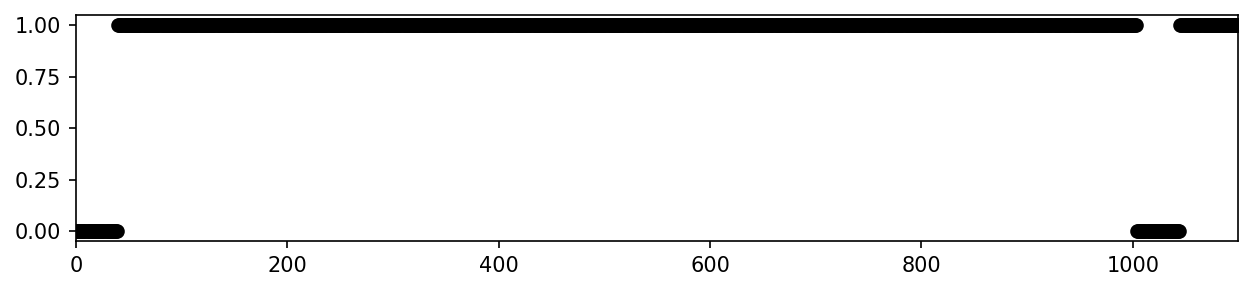

96114


In [252]:
##########################################################################################
# 3b) Define valid slices
##########################################################################################

##########################################################################################
# 3b)i) Hyperparameters
##########################################################################################
maxlen = 40
step = 1

##########################################################################################
# 3b)ii) Define valid slices
##########################################################################################
df["valid_slice_flag"]=False
matches = np.unique(df["MID"])
for m in matches:
  #print(m)
  idx = df["MID"] == m
  idxn = np.where(idx)[0]
  df.loc[idxn[maxlen::step],"valid_slice_flag"] = True     #the first slice will be start at "maxlen" into match; and then be offset by "step" until end of match
  df.loc[idxn[-1],"valid_slice_flag"] = False              #exclude the final row, which is the sample corresponding to EOM "@" action

fig, ax = plt.subplots(figsize=(10,2))
ax.scatter(range(len(df)),df["valid_slice_flag"],color="black")
ax.set_xlim(0,1100)
plt.show()
print(np.sum(df["valid_slice_flag"]))

In [253]:
##########################################################################################
# 3c) Define PyTorch dataset class and specific datasets instances and associated dataloaders
##########################################################################################

##########################################################################################
# 3c)i)   Define dataset class
##########################################################################################
class SoccerDataset(Dataset):
    # cut the text in semi-redundant sequences of maxlen characters
    def __init__(self,idx=idx_all):
        self.idx = idx
        self.valid_slice_idxn = np.where(np.logical_and(self.idx,df["valid_slice_flag"]))[0]  #in both the idx and has a valid slice flag
    def __len__(self):
        return int(np.sum(df.loc[self.idx,"valid_slice_flag"]))
    def __getitem__(self, i):
        j = self.valid_slice_idxn[i]
        y = df.iloc[j].loc[target_vars]
        x = df.iloc[(j-maxlen):j].loc[:,input_vars]
        return x.to_numpy(), y.to_numpy().astype(float)

##########################################################################################
# 3c)ii)  Define datasets
##########################################################################################
# define datasets
all_dataset = SoccerDataset()
trn_dataset = SoccerDataset(idx=idx_trn)
val_dataset = SoccerDataset(idx=idx_val)
tst_dataset = SoccerDataset(idx=idx_tst)
dmo_dataset = SoccerDataset(idx=idx_dmo)

##########################################################################################
# 3c)iii) Define dataloaders
##########################################################################################
batch_size, num_workers = 10, 2
all_loader = DataLoader(all_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
trn_loader = DataLoader(trn_dataset,shuffle=True,batch_size=batch_size,num_workers=num_workers,drop_last=True)
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
tst_loader = DataLoader(tst_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
dmo_loader = DataLoader(dmo_dataset,shuffle=False,batch_size=1,num_workers=num_workers)

In [254]:
##########################################################################################
# 4) Define categorical action encode/decode
##########################################################################################
# replace own goal "h" with goal "g" (rare instance... simplest solution for this version... to do 'properly' in future development...)
idx = df["act"] == "h"
df.loc[idx,"act"] = "g"

# set up idx2char and char2idx
chars = sorted(list(set(df['act'])))     # list of all unique characters in the text
num_chars_test = len(chars)                   
char2idx_test = dict((c, i) for i, c in enumerate(chars))
idx2char_test = dict((i, c) for i, c in enumerate(chars))

num_chars=7 # hyperparameter
idx2char = {0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
char2idx = {'@': 0, '_': 1, 'd': 2, 'g': 3, 'p': 4, 's': 5, 'x': 6}

# let's just check that our hard coded values match what's in the data at this point...
assert num_chars_test == num_chars
assert idx2char_test == idx2char
assert char2idx_test == char2idx

# replace characters with numbers
df['act'].replace(char2idx,inplace=True)
print(idx2char)

##########################################################################################
# 5) Specify variables of interest
##########################################################################################
input_vars  = ['act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']
target_vars = ['act', 'x', 'y']

#df.columns: ['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']

##########################################################################################
# 6) Specify loss function weighting
##########################################################################################
##########################################################################################
# 6a) Action, categorical
##########################################################################################
print(idx2char)
print(np.unique(df["act"],return_counts=True))
weights = char2idx.copy()
for x in weights: weights[x]=1
weights['@'] = 0
weights['_'] = 0
weights['d'] = 0.120  #10  #0.1 #7826/78659
weights['g'] = 0
weights['p'] = 0.013  #1.2 #0.84 #66026/78659
weights['s'] = 0.580  #50  #0.02 #1653/78659
weights['x'] = 0.29   #25  #0.04 #3154
print(weights)               #we are more accepting if the model doesn't predict low prob events like goals
weights = torch.tensor(list(weights.values()))
print(weights)

##########################################################################################
# 6b) All other variables, continuous
##########################################################################################
cont_weights = torch.tensor([1.,1.])
print(target_vars[1:])
print(cont_weights)

{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
(array([0, 1, 2, 3, 4, 5, 6]), array([  144, 18882,  8201,   192, 69422,  1742,  3312]))
{'@': 0, '_': 0, 'd': 0.12, 'g': 0, 'p': 0.013, 's': 0.58, 'x': 0.29}
tensor([0.0000, 0.0000, 0.1200, 0.0000, 0.0130, 0.5800, 0.2900])
['x', 'y']
tensor([1., 1.])


In [255]:
##########################################################################################
# 7) view_sample: a function to show us a sample based on the current model (e.g. used during training)
##########################################################################################
def view_sample(model=None,epoch=None,data_loader=None):
    t=0
    # epoch=t
    # data_loader=dmo_loader

    model.eval() #turn evaluation mode on if not already

    Yhat_all = np.empty((0,num_chars + len(target_vars) - 1))
    Y_all    = np.empty((0,len(target_vars)))
    loss_all = np.empty((0,3))
    for X,Y in data_loader:        
        X, Y = X.to(device), Y.to(device)
        #X[:,:,1:] = torch.round(X[:,:,1:]*4)/4
        #Y[:,1:] = torch.round(Y[:,1:]*8)/8

        Yhat = model(X)
        #Yhat[:,7:] = torch.round(Yhat[:,7:]*8)/8

        loss = (torch.Tensor([0.]),torch.Tensor([0.]),torch.Tensor([0.]))
        Yhat = Yhat.detach().cpu()
        Y    = Y.cpu()

        Yhat_all = np.vstack((Yhat_all,Yhat))
        Y_all = np.vstack((Y_all,Y))
        loss_all = np.vstack((loss_all,np.array([loss[0].detach().cpu(),loss[1].detach().cpu(),loss[2].detach().cpu()])))

    # apply softmax to Yhat categorical
    from scipy.special import softmax
    Yhat_all[:,:num_chars] = softmax(Yhat_all[:,:num_chars],1)
    # argmax of Yhat categorical
    Yhat_cat_argmax = np.vectorize(idx2char.get)(np.argmax(Yhat_all[:,:num_chars],axis=1))
    Yhat_cat_argmax = np.array(Yhat_cat_argmax).reshape(len(np.array(Yhat_cat_argmax)),1)
    # string of Y_cat action
    Y_cat = np.vectorize(idx2char.get)(Y_all[:,0])
    Y_cat = np.array(Y_cat).reshape(len(np.array(Y_cat)),1)

    demo_df = pd.DataFrame(np.hstack((Yhat_all,Yhat_cat_argmax,Y_cat,Y_all,loss_all)))
    demo_df_colnames = [str(m)+str(n) for m,n in zip(list(idx2char.keys()),list(idx2char.values()))]
    demo_df_colnames.extend(["Yhat_"+str(n) for n in target_vars[1:]])
    demo_df_colnames.extend(["Yhat_act","Y_act","Y_act_idxn"])
    demo_df_colnames.extend(["Y_"+str(n) for n in target_vars[1:]])  #"Y_x0","Y_y0","Y_s","Y_deltax0","Y_deltay0",
    demo_df_colnames.extend(["Yhat_totL","Yhat_CEL","Yhat_MSEL"])
    demo_df.columns = demo_df_colnames
    # demo_df.to_csv("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/3progressJUL/demo_df.csv")

    import textwrap
    a0 = textwrap.wrap(demo_df["Yhat_act"].str.cat(),100)
    a1 = textwrap.wrap(demo_df["Y_act"].str.cat(),100)

    print("Predicted ------------------------------------------------------------------------------------------")
    print("Actual    ------------------------------------------------------------------------------------------\n")
    for i in range(len(a0)):
      print(a0[i])
      print(a1[i])
      print()

    cols = ["Actual"]
    cols.extend(list(char2idx.keys()))
    act_accuracy = pd.DataFrame(columns=cols)
    for i in list(char2idx.keys()):
      k_row = np.array([i])
      
      i_preds = demo_df["Yhat_act"][demo_df["Y_act"] == i]
      for j in list(char2idx.keys()):
        k_row = np.append(k_row,int(np.sum(i_preds == j)))

      k_row2 = pd.DataFrame(k_row).T
      k_row2.columns = cols

      act_accuracy = pd.concat([act_accuracy,k_row2],ignore_index=True)

    print(act_accuracy)

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="red")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="red")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      ax.set_xlim(200,250)
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")
      
      pred[demo_df["Y_act"]=="_"]=None
      act[demo_df["Y_act"]=="_"]=None
      
      fig, ax = plt.subplots(figsize=(8,2))
      ax.plot(range(len(act)),act,color="black")
      ax.plot(range(len(pred)),pred,color="blue")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_title(f"{tempvar}, epoch {t}; actual (black) vs predicted (red)")
      ax.set_xlim(200,250)
      plt.show()

    # fig, ax = plt.subplots(figsize=(10,5))
    # pred_x = demo_df["Yhat_x0"].astype("float")
    # act_x  = demo_df["Y_"+"x0"].astype("float")
    # pred_y = demo_df["Yhat_y0"].astype("float")
    # act_y  = demo_df["Y_"+"y0"].astype("float")
    # ax.plot(act_x[200:250],act_y[200:250],color="black")
    # ax.plot(pred_x[200:250],pred_y[200:250],color="red")
    # plt.show()


    fig, ax = plt.subplots(figsize=(4,4))
    ax.grid(); ax.set_axisbelow(True)
    colors=['red','orange','yellow','green','blue','indigo','violet']; i = 0
    color_title = ''
    for tempvar in target_vars[1:]:
      col = colors[i]; i+=1
      color_title += tempvar+" ("+col+") "
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      ax.scatter(pred,act,color=col,alpha=0.5,edgecolor='none')

      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")

    ax.set_title(f"All continuous random variables, epoch {t} \n{color_title}")
    ax.plot([0,1],[0,1],color="black")
    plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(df[tempvar][1:].to_numpy(), df[tempvar][:-1].to_numpy(),alpha=0.02,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")
      act  = demo_df["Y_"+tempvar].astype("float")

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(demo_df["Y_"+tempvar][1:].astype(float).to_numpy(),
                  demo_df["Y_"+tempvar][:-1].astype(float).to_numpy(),alpha=0.5,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()

    idx0 = np.logical_or(demo_df["Y_act"] == "_",demo_df["Y_act"] == "@")
    idx1 = np.append(True,idx0[1:])
    idx2 = np.logical_or(idx0,idx1)
    idx3 = ~idx2

    for tempvar in target_vars[1:]:
      pred = demo_df["Yhat_"+tempvar].astype("float")[idx3]
      act  = demo_df["Y_"+tempvar].astype("float")[idx3]
      act1 = np.append(0.,act[:-1])

      fig, ax = plt.subplots(figsize=(4,4))
      ax.scatter(demo_df["Y_"+tempvar][1:].astype(float).to_numpy(),
                  demo_df["Y_"+tempvar][:-1].astype(float).to_numpy(),alpha=0.5,edgecolor="none")
      ax.scatter(pred, act,alpha=0.5,edgecolor="none")
      ax.grid(); ax.set_axisbelow(True)
      ax.set_xlabel("Predicted")
      ax.set_ylabel("Actual")
      ax.set_title(tempvar)
      ax.plot([0,1],[0,1],color="black")
      plt.show()
      fig, ax = plt.subplots()
      sns.kdeplot(pred-act,ax=ax,color="red")
      sns.kdeplot(act1-act,ax=ax,color="black")
      plt.show()


#Model Definition


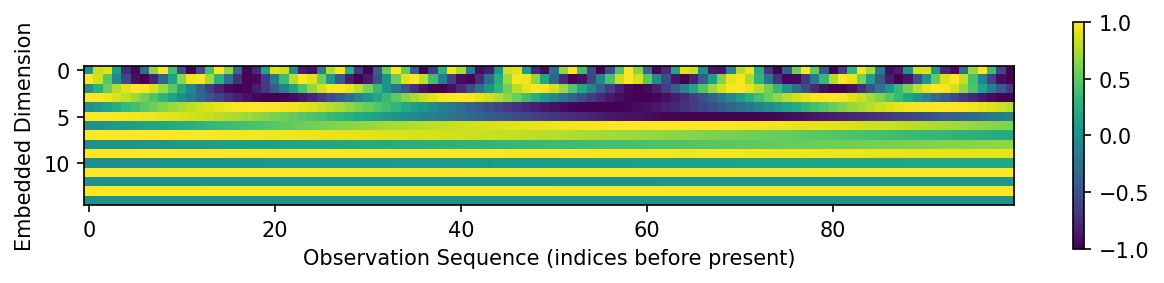

In [256]:
##########################################################################################
# 8) generate_positional_encoding: for Transformer encoder component
##########################################################################################
def ian_generate_positional_encoding(src):
  # src = X_cat0; d_model = 15

  pos_encoding = torch.zeros_like(src[0])
  seq_len = pos_encoding.shape[0]
  d_model = pos_encoding.shape[1]

  for i in range(d_model):
    for pos in range(seq_len):
      if i % 2 == 0:
        pos_encoding[pos,i] = np.sin(pos/100**(2*i/d_model))
      else:
        pos_encoding[pos,i] = np.cos(pos/100**(2*i/d_model))
  # plt.imshow(pos_encoding.cpu().numpy())
  return pos_encoding.float()

fig, ax = plt.subplots(figsize=[10,2])
im = ax.imshow(ian_generate_positional_encoding(torch.zeros(1,100,15)).T)
ax.set_xlabel("Observation Sequence (indices before present)")
ax.set_ylabel("Embedded Dimension")
fig.colorbar(im,ax=ax)

In [257]:
##########################################################################################
# 9) Seq2Event Soccer Model (Transformer, ElmanRNN, LSTM, GRU)
##########################################################################################

##########################################################################################
# 9a) Model class
##########################################################################################
class Soccer_Model_3ze(nn.Module):
    def __init__(self):  #pick up all specification vars from the global environment
        super(Soccer_Model_3ze, self).__init__() 
        self.emb = nn.Embedding(num_action_cats,cat_embedding_dim,padding_idx=act_padding_idx,scale_grad_by_freq=scale_grad_by_freq)
        self.lin0 = nn.Linear(num_contvars_in,cont_embedding_dim,bias=True)
        if model_type == "Transformer":
          #self.msk = torch.nn.Transformer.generate_square_subsequent_mask(self,maxlen-1).to(device)
          self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,nhead=transformer_nhead,batch_first=True,dim_feedforward=dim_feedforward).to(device)
          self.seqnet = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        if model_type == "ElmanRNN":
          self.seqnet =  nn.RNN(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True,nonlinearity=ElmanRNN_nonlinearity)
        if model_type == "GRU":
          self.seqnet =  nn.LSTM(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True)
        if model_type == "LSTM":
          self.seqnet =  nn.LSTM(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True)

        if model_type == "Transformer":
          self.lin1 = nn.Linear(d_model,transformer_finaldenselayer_dim)
        elif bidirectional:
          self.lin1 = nn.Linear(dim_feedforward*2,transformer_finaldenselayer_dim)
        else:
          self.lin1 = nn.Linear(dim_feedforward,transformer_finaldenselayer_dim)
        self.lin2 = nn.Linear(transformer_finaldenselayer_dim, num_action_cats + num_contvars_out,bias=True)
        print(self)        

    def forward(self, X):
        global testX, X_cat_seqnet
        testX = X
        #X = testX
        X_acts = X[:,:,0].int()
        X_actsemb = self.emb(X_acts)
        X_cont = X[:,:,1:]
        X_cont = self.lin0(X_cont.float())
              
        X_cat = torch.cat([X_actsemb,X_cont],dim=2)
        X_cat = X_cat.float()

        src = X_cat + ian_generate_positional_encoding(X_cat).to(device)
        if model_type == "Transformer":
          X_cat_seqnet = self.seqnet(src)
        else:
          X_cat_seqnet,_ = self.seqnet(src)

        out = self.lin1(X_cat_seqnet[:,-1,:])
        out = F.relu(out)
        out = self.lin2(out)
        return out

##########################################################################################
# 9b) Loss function
##########################################################################################
def Soccer_Model_3_lossfn_3ze(X, Yhat, Y, cat_weight=5.,cont_weight=1.):
        global testX, testYhat, testY
        testX, testYhat, testY = X, Yhat,Y
        #X, Yhat,Y = testX, testYhat, testY
                
        Y_acts = Y[:,0].long()
        Yminus1_acts = X[:,-1,0].long()
        Y_cont = Y[:,1:].float()

        Yhat_acts = Yhat[:,:num_chars]          #; Yhat_acts.shape  #10/13
        Yhat_cont = Yhat[:,num_chars:].float()  #; Yhat_cont.shape  #10/5
        #Yhat_cont = torch.clamp(Yhat_cont,min=0,max=1)   #clamp the cont RVs to the range [0,1]

        CEL = nn.CrossEntropyLoss(weight=weights.to(device),reduction="none")
        #MSEL = nn.MSELoss(reduction="none")
        #MSEL = nn.L1Loss(reduction="none")
        #MSEL = nn.MSELoss(reduction="none")

        Yhat_CEL  = torch.mean(CEL(Yhat_acts,Y_acts)) * cat_weight #/ torch.std(CEL(Yhat_acts,Y_acts))
        #Yhat_MSEL = MSEL(Yhat_cont,Y_cont.float())**2
        Yhat_MSEL= (Yhat_cont-Y_cont.float())**2
        #Yhat_MSEL[Yhat_MSEL > 0.15] = 100
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)     
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)       
        #target_vars   #['act', 's', 'deltax0', 'deltay0', 'deltaT']
        #Yhat_MSEL= abs(Yhat_cont-Y_cont.float())
        
        
        idx_ignorecurrent = torch.logical_or(Y_acts == 0, Y_acts == 1)             #idx2char # 0 @, 1_ #ASKING, IS THE CURRENT ACTION ONE TO IGNORE?
        idx_ignoreminus1  = torch.logical_or(Yminus1_acts == 0, Yminus1_acts == 1) #idx2char # 0 @, 1_ #ASKING, IS THE CURRENT ACTION ONE TO IGNORE BASED ON ACTION BEFORE?
        idx_ignore = torch.logical_or(idx_ignorecurrent,idx_ignoreminus1)
        if torch.sum(idx_ignore) == 0:    #if nothing to ignore...
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight
        elif torch.sum(~idx_ignore) == 0:   #if everything to be ignored...
          #print("ignoring all MSEL")
          Yhat_MSEL = torch.Tensor([0.]).to(device)
        else:
          Yhat_MSEL = Yhat_MSEL[~idx_ignore,:]        
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight #/ torch.std(Yhat_MSEL)
         
        Yhat_totL = Yhat_CEL + Yhat_MSEL
        return Yhat_totL, Yhat_CEL, Yhat_MSEL

# Model Training

In [258]:
##########################################################################################
# 10) Define epoch function and training(/validation+test) function
##########################################################################################

##########################################################################################
# 10a) do_epoch: run one epoch
##########################################################################################
def do_epoch(dataloader, model, loss_fn, optimiser, scheduler, epochtype="tst"):
  if np.isin(epochtype,["tst","val"]): 
    model.eval()     #turn training off if (val or test)
  if epochtype == "trn":
    model.train()    #turn training on if not (val or test)
    
  size = len(dataloader.dataset)
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = 0., 0., 0.
  for batch, (X, Y) in enumerate(dataloader):
      X, Y = X.to(device), Y.to(device)
      
      pred = model(X)

      loss, lossCEL, lossMSE = loss_fn(X, pred, Y)
      loss_rollingmean = loss_rollingmean+(loss-loss_rollingmean)/(1+batch)
      lossCEL_rollingmean = lossCEL_rollingmean+(lossCEL-lossCEL_rollingmean)/(1+batch)
      lossMSE_rollingmean = lossMSE_rollingmean+(lossMSE-lossMSE_rollingmean)/(1+batch)

      if epochtype == "trn":
        # Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

      if batch % 500 == 0:
        loss, current = loss.item(), batch * X.shape[0]
        print(f"loss: {loss:>7f}, ln(1+loss): {np.log(1+loss):>7f} | CEloss: {lossCEL:>7f}, MSEloss: {lossMSE} | batch: {batch} | sample: [{current:>5d}/{size:>5d}] | lr: {optimiser.param_groups[0]['lr']}")
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = loss_rollingmean.detach().cpu().numpy().item(), lossCEL_rollingmean.detach().cpu().numpy().item(), lossMSE_rollingmean.detach().cpu().numpy().item()  
  print(f"Epoch loss:    mean: {loss_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+loss_rollingmean):>7f}")
  print(f"Epoch CEloss:  mean: {lossCEL_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossCEL_rollingmean):>7f}")
  print(f"Epoch MSEloss: mean: {lossMSE_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossMSE_rollingmean):>7f}")
  if epochtype == "val":
    scheduler.step(loss_rollingmean); print("scheduler.step performed after val loop")   #step scheduler if val
  return loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean

##########################################################################################
# 10b) DEFINE TRAINING AND VALIDATION CYCLES
##########################################################################################
def go():
  torch.cuda.empty_cache(); import gc; gc.collect()
  global model
  #model = Soccer_Model_3ze(hidden_size=128,num_layers=1,cat_embedding_dim=num_chars,dropout=0.2).to(device)
  model = Soccer_Model_3ze().to(device)
  loss_fn    = Soccer_Model_3_lossfn_3ze
  #optimiser  = optim.RMSprop(model.parameters(),lr=0.01,eps=1e-16)
  optimiser  = optim.Adam(model.parameters(),lr=0.01,eps=1e-16)
  scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser,factor=.1,patience=3,verbose=True)

  #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1GRU20210816star3"))

  loss_hist = pd.DataFrame(columns=["epoch","trn_L","trn_CEL","trn_MSEL","val_L","val_CEL","val_MSEL","tst_L","tst_CEL","tst_MSEL"])
  epochs=50
  for t in range(epochs):
      torch.cuda.empty_cache(); import gc; gc.collect()
      print(f"Epoch {t}\n-------------------------------")
      trainloss = do_epoch(trn_loader, model, loss_fn, optimiser, scheduler,epochtype="trn")   #TRAIN - the important bit!!
      valloss = do_epoch(val_loader, model, loss_fn, optimiser, scheduler,epochtype="val")     #VALIDATION set evaluation

      epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.asarray(trainloss),np.asarray(valloss),np.array(["","",""])))).T
      epochloss.columns = loss_hist.columns
      loss_hist = loss_hist.append(epochloss)
          
      fig, ax = plt.subplots(3,1,figsize=(4,2))
      ax[0].plot(range(len(loss_hist)),loss_hist["trn_L"].astype(float),color="black",lw=0.5); ax[0].plot(range(len(loss_hist)),loss_hist["val_L"].astype(float),color="red",lw=0.5); ax[0].set_title("Loss"); ax[0].grid(); ax[0].set_axisbelow(True)
      ax[1].plot(range(len(loss_hist)),loss_hist["trn_CEL"].astype(float),color="black",lw=0.5); ax[1].plot(range(len(loss_hist)),loss_hist["val_CEL"].astype(float),color="red",lw=0.5); ax[1].set_title("CELoss"); ax[1].grid(); ax[2].set_axisbelow(True)
      ax[2].plot(range(len(loss_hist)),loss_hist["trn_MSEL"].astype(float),color="black",lw=0.5); ax[2].plot(range(len(loss_hist)),loss_hist["val_MSEL"].astype(float),color="red",lw=0.5); ax[2].set_title("MSELoss"); ax[2].grid(); ax[2].set_axisbelow(True)
      plt.show()

      #every n cycles during training... can view a sample and/or save the current model state (useful if training spans several hours in case of Colab timeout)
      # if t % 10 == 0:
      # #if t == 1:
      #   view_sample(model,t,dmo_loader)
      #   date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
      #   torch.save(model.state_dict(), f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_{date}") # hidden size 20, num_layers = 10
      #   #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1"))
      if optimiser.param_groups[0]["lr"] < 1E-7:
        break
  date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
  torch.save(model.state_dict(), f"/content/gdrive/MyDrive/SEQ2Event_github/NB2_Outputs_v202208/MDLstate_{date}")
  torch.cuda.empty_cache(); import gc; gc.collect()
  view_sample(model,t,dmo_loader)
  print("Calculating test loss")
  tstloss = do_epoch(tst_loader, model, loss_fn, optimiser, scheduler,epochtype="tst")
  epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.array(["","","","","",""]),np.asarray(tstloss)))).T
  epochloss.columns = loss_hist.columns
  loss_hist = loss_hist.append(epochloss)
  final_loss = np.append(np.append(trainloss,valloss),tstloss)
  return final_loss

Soccer_Model_3ze(
  (emb): Embedding(7, 7, padding_idx=1, scale_grad_by_freq=True)
  (lin0): Linear(in_features=10, out_features=10, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
    )
    (linear1): Linear(in_features=17, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=17, bias=True)
    (norm1): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (seqnet): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
        )
        (linear1): Linear(in_

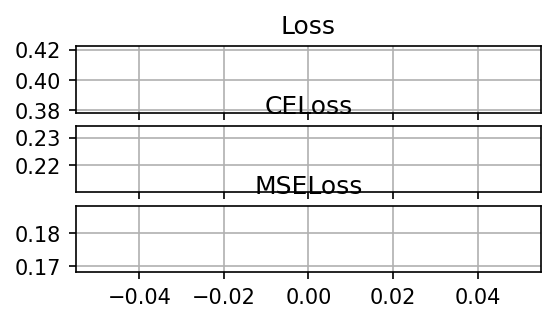

Epoch 1
-------------------------------
loss: 0.262936, ln(1+loss): 0.233439 | CEloss: 0.118388, MSEloss: 0.1445479840040207 | batch: 0 | sample: [    0/45675] | lr: 0.01
loss: 0.729436, ln(1+loss): 0.547796 | CEloss: 0.595794, MSEloss: 0.13364259898662567 | batch: 500 | sample: [ 5000/45675] | lr: 0.01
loss: 0.857909, ln(1+loss): 0.619452 | CEloss: 0.570917, MSEloss: 0.28699156641960144 | batch: 1000 | sample: [10000/45675] | lr: 0.01
loss: 0.476964, ln(1+loss): 0.389988 | CEloss: 0.330467, MSEloss: 0.14649663865566254 | batch: 1500 | sample: [15000/45675] | lr: 0.01
loss: 0.235780, ln(1+loss): 0.211702 | CEloss: 0.058937, MSEloss: 0.17684301733970642 | batch: 2000 | sample: [20000/45675] | lr: 0.01
loss: 1.221275, ln(1+loss): 0.798081 | CEloss: 0.952081, MSEloss: 0.2691945731639862 | batch: 2500 | sample: [25000/45675] | lr: 0.01
loss: 0.268077, ln(1+loss): 0.237502 | CEloss: 0.061524, MSEloss: 0.20655354857444763 | batch: 3000 | sample: [30000/45675] | lr: 0.01
loss: 0.517670, ln(1+

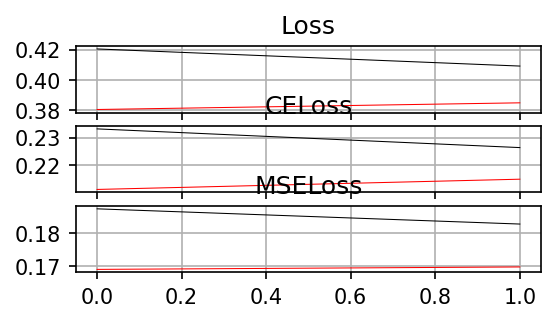

Epoch 2
-------------------------------
loss: 0.272090, ln(1+loss): 0.240661 | CEloss: 0.110344, MSEloss: 0.16174668073654175 | batch: 0 | sample: [    0/45675] | lr: 0.01
loss: 0.428386, ln(1+loss): 0.356545 | CEloss: 0.261363, MSEloss: 0.16702266037464142 | batch: 500 | sample: [ 5000/45675] | lr: 0.01
loss: 0.154185, ln(1+loss): 0.143394 | CEloss: 0.041363, MSEloss: 0.11282128095626831 | batch: 1000 | sample: [10000/45675] | lr: 0.01
loss: 0.170960, ln(1+loss): 0.157824 | CEloss: 0.053875, MSEloss: 0.11708447337150574 | batch: 1500 | sample: [15000/45675] | lr: 0.01
loss: 0.296151, ln(1+loss): 0.259399 | CEloss: 0.181206, MSEloss: 0.11494461447000504 | batch: 2000 | sample: [20000/45675] | lr: 0.01
loss: 0.574570, ln(1+loss): 0.453982 | CEloss: 0.396703, MSEloss: 0.17786714434623718 | batch: 2500 | sample: [25000/45675] | lr: 0.01
loss: 0.269968, ln(1+loss): 0.238992 | CEloss: 0.111799, MSEloss: 0.15816883742809296 | batch: 3000 | sample: [30000/45675] | lr: 0.01
loss: 0.559491, ln(

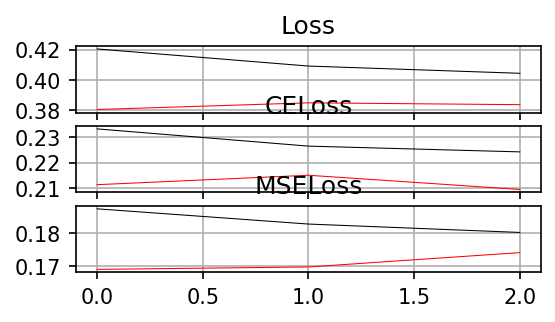

Epoch 3
-------------------------------
loss: 0.350690, ln(1+loss): 0.300615 | CEloss: 0.157547, MSEloss: 0.19314280152320862 | batch: 0 | sample: [    0/45675] | lr: 0.01
loss: 1.390125, ln(1+loss): 0.871346 | CEloss: 1.208037, MSEloss: 0.18208791315555573 | batch: 500 | sample: [ 5000/45675] | lr: 0.01
loss: 0.176096, ln(1+loss): 0.162200 | CEloss: 0.051803, MSEloss: 0.12429257482290268 | batch: 1000 | sample: [10000/45675] | lr: 0.01
loss: 0.299742, ln(1+loss): 0.262165 | CEloss: 0.126610, MSEloss: 0.1731318235397339 | batch: 1500 | sample: [15000/45675] | lr: 0.01
loss: 0.291113, ln(1+loss): 0.255505 | CEloss: 0.105221, MSEloss: 0.1858915090560913 | batch: 2000 | sample: [20000/45675] | lr: 0.01
loss: 0.322315, ln(1+loss): 0.279384 | CEloss: 0.060027, MSEloss: 0.262288361787796 | batch: 2500 | sample: [25000/45675] | lr: 0.01
loss: 0.292325, ln(1+loss): 0.256443 | CEloss: 0.091501, MSEloss: 0.2008243054151535 | batch: 3000 | sample: [30000/45675] | lr: 0.01
loss: 0.366300, ln(1+los

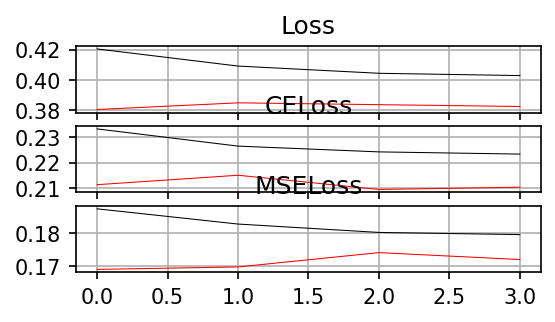

Epoch 4
-------------------------------
loss: 0.234260, ln(1+loss): 0.210472 | CEloss: 0.051223, MSEloss: 0.18303728103637695 | batch: 0 | sample: [    0/45675] | lr: 0.01
loss: 0.449762, ln(1+loss): 0.371400 | CEloss: 0.252727, MSEloss: 0.19703544676303864 | batch: 500 | sample: [ 5000/45675] | lr: 0.01
loss: 0.625154, ln(1+loss): 0.485603 | CEloss: 0.441641, MSEloss: 0.18351304531097412 | batch: 1000 | sample: [10000/45675] | lr: 0.01
loss: 0.438038, ln(1+loss): 0.363280 | CEloss: 0.325831, MSEloss: 0.11220644414424896 | batch: 1500 | sample: [15000/45675] | lr: 0.01
loss: 0.271567, ln(1+loss): 0.240250 | CEloss: 0.139410, MSEloss: 0.13215787708759308 | batch: 2000 | sample: [20000/45675] | lr: 0.01
loss: 0.249536, ln(1+loss): 0.222772 | CEloss: 0.073190, MSEloss: 0.17634518444538116 | batch: 2500 | sample: [25000/45675] | lr: 0.01
loss: 0.205131, ln(1+loss): 0.186588 | CEloss: 0.037015, MSEloss: 0.16811628639698029 | batch: 3000 | sample: [30000/45675] | lr: 0.01
loss: 0.251132, ln(

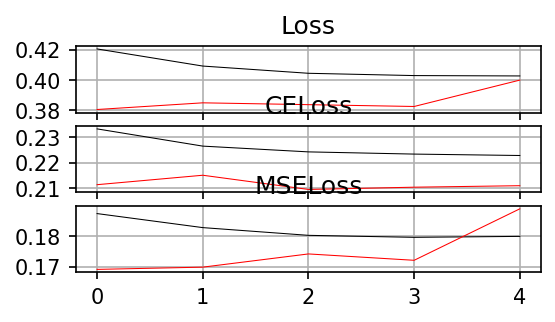

Epoch 5
-------------------------------
loss: 0.498275, ln(1+loss): 0.404315 | CEloss: 0.247651, MSEloss: 0.2506239712238312 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.529897, ln(1+loss): 0.425200 | CEloss: 0.407402, MSEloss: 0.12249454110860825 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.863315, ln(1+loss): 0.622357 | CEloss: 0.691631, MSEloss: 0.17168405652046204 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.498023, ln(1+loss): 0.404146 | CEloss: 0.333577, MSEloss: 0.16444644331932068 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.348699, ln(1+loss): 0.299141 | CEloss: 0.122209, MSEloss: 0.22649042308330536 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.245906, ln(1+loss): 0.219863 | CEloss: 0.114595, MSEloss: 0.13131120800971985 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.165386, ln(1+loss): 0.153052 | CEloss: 0.059578, MSEloss: 0.10580846667289734 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.26321

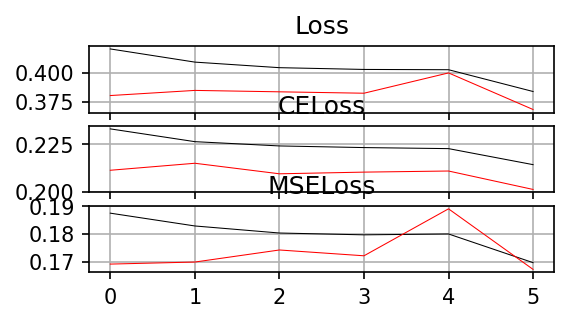

Epoch 6
-------------------------------
loss: 0.723905, ln(1+loss): 0.544592 | CEloss: 0.512567, MSEloss: 0.21133795380592346 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.189699, ln(1+loss): 0.173700 | CEloss: 0.061573, MSEloss: 0.12812569737434387 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.594200, ln(1+loss): 0.466372 | CEloss: 0.448149, MSEloss: 0.14605078101158142 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.315901, ln(1+loss): 0.274521 | CEloss: 0.114294, MSEloss: 0.2016061693429947 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.297086, ln(1+loss): 0.260121 | CEloss: 0.110240, MSEloss: 0.18684615194797516 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.292706, ln(1+loss): 0.256737 | CEloss: 0.111433, MSEloss: 0.18127267062664032 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.359362, ln(1+loss): 0.307015 | CEloss: 0.230057, MSEloss: 0.12930458784103394 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.27167

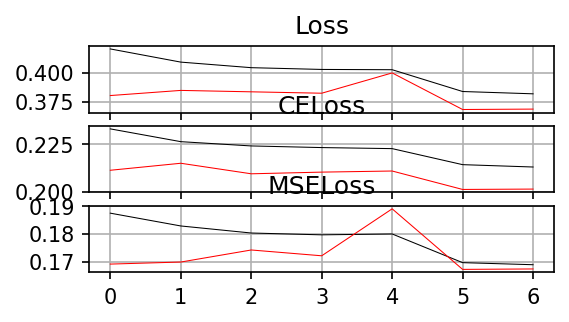

Epoch 7
-------------------------------
loss: 0.283998, ln(1+loss): 0.249979 | CEloss: 0.179773, MSEloss: 0.10422482341527939 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.341911, ln(1+loss): 0.294095 | CEloss: 0.199580, MSEloss: 0.1423313319683075 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.435865, ln(1+loss): 0.361767 | CEloss: 0.305292, MSEloss: 0.13057345151901245 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.284850, ln(1+loss): 0.250642 | CEloss: 0.133347, MSEloss: 0.1515032947063446 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.194456, ln(1+loss): 0.177691 | CEloss: 0.111278, MSEloss: 0.08317865431308746 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.488055, ln(1+loss): 0.397470 | CEloss: 0.323244, MSEloss: 0.16481105983257294 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.544416, ln(1+loss): 0.434646 | CEloss: 0.386501, MSEloss: 0.15791501104831696 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.256358

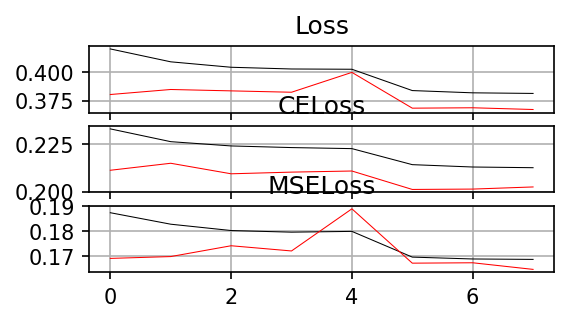

Epoch 8
-------------------------------
loss: 0.705530, ln(1+loss): 0.533876 | CEloss: 0.442463, MSEloss: 0.2630671262741089 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.335703, ln(1+loss): 0.289458 | CEloss: 0.142334, MSEloss: 0.1933695524930954 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.880396, ln(1+loss): 0.631483 | CEloss: 0.665939, MSEloss: 0.21445707976818085 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.284654, ln(1+loss): 0.250490 | CEloss: 0.080540, MSEloss: 0.20411407947540283 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.446594, ln(1+loss): 0.369211 | CEloss: 0.307842, MSEloss: 0.13875162601470947 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.430012, ln(1+loss): 0.357683 | CEloss: 0.227073, MSEloss: 0.2029397338628769 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.299333, ln(1+loss): 0.261851 | CEloss: 0.071604, MSEloss: 0.2277294099330902 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.365332, 

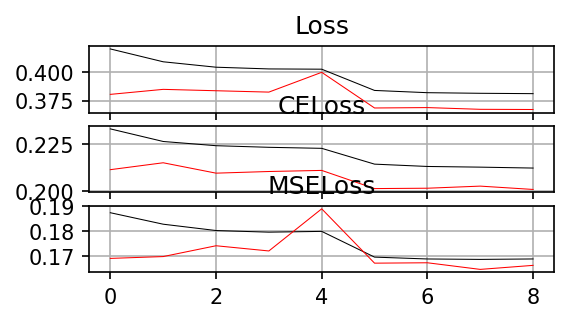

Epoch 9
-------------------------------
loss: 0.226858, ln(1+loss): 0.204457 | CEloss: 0.043149, MSEloss: 0.18370981514453888 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.423847, ln(1+loss): 0.353362 | CEloss: 0.334042, MSEloss: 0.08980432152748108 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.220239, ln(1+loss): 0.199047 | CEloss: 0.050157, MSEloss: 0.1700821965932846 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.364874, ln(1+loss): 0.311062 | CEloss: 0.236371, MSEloss: 0.1285030096769333 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.191972, ln(1+loss): 0.175609 | CEloss: 0.057737, MSEloss: 0.13423489034175873 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.401547, ln(1+loss): 0.337577 | CEloss: 0.172468, MSEloss: 0.22907894849777222 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.494795, ln(1+loss): 0.401989 | CEloss: 0.335042, MSEloss: 0.1597527712583542 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.428866,

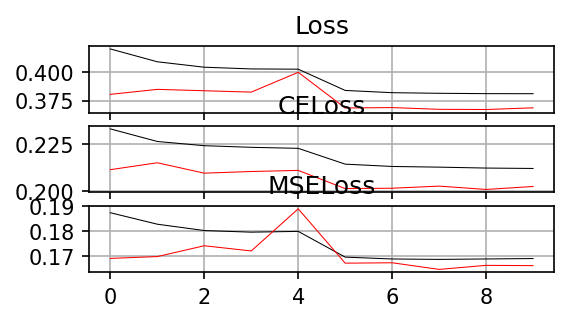

Epoch 10
-------------------------------
loss: 0.521371, ln(1+loss): 0.419612 | CEloss: 0.317220, MSEloss: 0.20415057241916656 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.370674, ln(1+loss): 0.315302 | CEloss: 0.285898, MSEloss: 0.0847761482000351 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.221922, ln(1+loss): 0.200425 | CEloss: 0.073948, MSEloss: 0.14797426760196686 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.154209, ln(1+loss): 0.143415 | CEloss: 0.045145, MSEloss: 0.10906334966421127 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.308174, ln(1+loss): 0.268632 | CEloss: 0.054455, MSEloss: 0.2537194788455963 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.268093, ln(1+loss): 0.237514 | CEloss: 0.086419, MSEloss: 0.18167433142662048 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.309600, ln(1+loss): 0.269722 | CEloss: 0.080132, MSEloss: 0.22946828603744507 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.23150

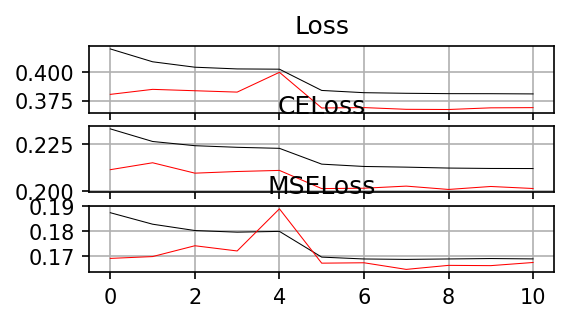

Epoch 11
-------------------------------
loss: 0.729417, ln(1+loss): 0.547784 | CEloss: 0.573350, MSEloss: 0.15606680512428284 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.487437, ln(1+loss): 0.397054 | CEloss: 0.376121, MSEloss: 0.11131522059440613 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.280458, ln(1+loss): 0.247218 | CEloss: 0.159843, MSEloss: 0.12061421573162079 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.461931, ln(1+loss): 0.379758 | CEloss: 0.361456, MSEloss: 0.10047458112239838 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.196949, ln(1+loss): 0.179776 | CEloss: 0.059730, MSEloss: 0.13721869885921478 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.697663, ln(1+loss): 0.529252 | CEloss: 0.559417, MSEloss: 0.1382453441619873 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.350955, ln(1+loss): 0.300812 | CEloss: 0.172632, MSEloss: 0.1783231645822525 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.23843

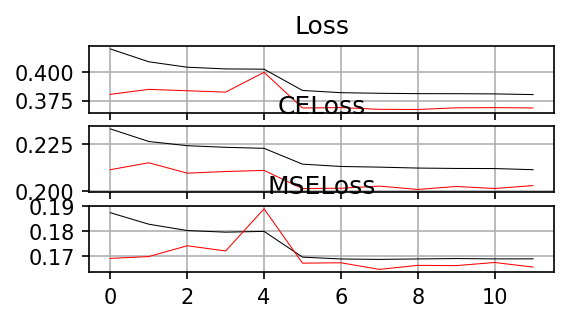

Epoch 12
-------------------------------
loss: 0.249307, ln(1+loss): 0.222589 | CEloss: 0.109795, MSEloss: 0.13951228559017181 | batch: 0 | sample: [    0/45675] | lr: 0.001
loss: 0.588181, ln(1+loss): 0.462590 | CEloss: 0.365945, MSEloss: 0.22223608195781708 | batch: 500 | sample: [ 5000/45675] | lr: 0.001
loss: 0.356598, ln(1+loss): 0.304980 | CEloss: 0.216060, MSEloss: 0.1405378133058548 | batch: 1000 | sample: [10000/45675] | lr: 0.001
loss: 0.626817, ln(1+loss): 0.486625 | CEloss: 0.431151, MSEloss: 0.19566576182842255 | batch: 1500 | sample: [15000/45675] | lr: 0.001
loss: 0.228525, ln(1+loss): 0.205814 | CEloss: 0.036319, MSEloss: 0.1922057867050171 | batch: 2000 | sample: [20000/45675] | lr: 0.001
loss: 0.408715, ln(1+loss): 0.342678 | CEloss: 0.248311, MSEloss: 0.16040387749671936 | batch: 2500 | sample: [25000/45675] | lr: 0.001
loss: 0.269344, ln(1+loss): 0.238500 | CEloss: 0.077134, MSEloss: 0.1922098994255066 | batch: 3000 | sample: [30000/45675] | lr: 0.001
loss: 0.277199

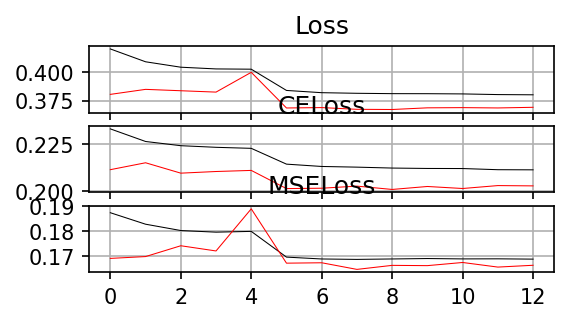

Epoch 13
-------------------------------
loss: 0.290442, ln(1+loss): 0.254985 | CEloss: 0.067969, MSEloss: 0.22247262299060822 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.685326, ln(1+loss): 0.521959 | CEloss: 0.339174, MSEloss: 0.34615185856819153 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.247521, ln(1+loss): 0.221158 | CEloss: 0.083236, MSEloss: 0.1642851084470749 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.330385, ln(1+loss): 0.285468 | CEloss: 0.178518, MSEloss: 0.15186703205108643 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.746659, ln(1+loss): 0.557705 | CEloss: 0.552775, MSEloss: 0.1938846856355667 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.271185, ln(1+loss): 0.239950 | CEloss: 0.099501, MSEloss: 0.17168448865413666 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.339316, ln(1+loss): 0.292159 | CEloss: 0.110271, MSEloss: 0.22904498875141144 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 

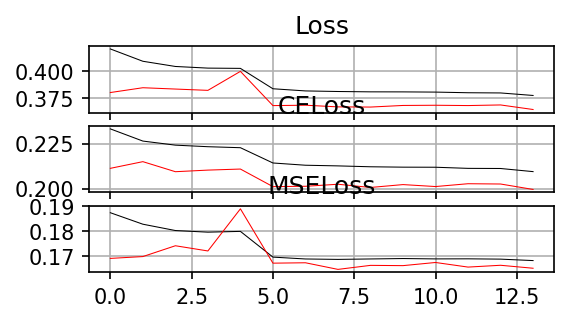

Epoch 14
-------------------------------
loss: 0.450420, ln(1+loss): 0.371853 | CEloss: 0.270341, MSEloss: 0.1800791621208191 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.395204, ln(1+loss): 0.333040 | CEloss: 0.285456, MSEloss: 0.10974723845720291 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.376576, ln(1+loss): 0.319600 | CEloss: 0.248221, MSEloss: 0.12835584580898285 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.308599, ln(1+loss): 0.268957 | CEloss: 0.107839, MSEloss: 0.20075955986976624 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.319332, ln(1+loss): 0.277126 | CEloss: 0.097290, MSEloss: 0.22204233705997467 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.653634, ln(1+loss): 0.502975 | CEloss: 0.439516, MSEloss: 0.2141183763742447 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.383345, ln(1+loss): 0.324504 | CEloss: 0.113078, MSEloss: 0.27026626467704773 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 

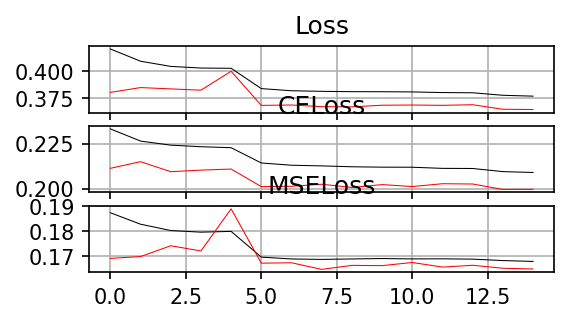

Epoch 15
-------------------------------
loss: 0.399073, ln(1+loss): 0.335810 | CEloss: 0.189589, MSEloss: 0.20948435366153717 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.298117, ln(1+loss): 0.260914 | CEloss: 0.167939, MSEloss: 0.13017787039279938 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.666127, ln(1+loss): 0.510502 | CEloss: 0.522538, MSEloss: 0.14358901977539062 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.618918, ln(1+loss): 0.481758 | CEloss: 0.384949, MSEloss: 0.2339683175086975 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.228996, ln(1+loss): 0.206198 | CEloss: 0.105380, MSEloss: 0.12361594289541245 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.756792, ln(1+loss): 0.563489 | CEloss: 0.549608, MSEloss: 0.20718447864055634 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.275381, ln(1+loss): 0.243245 | CEloss: 0.097043, MSEloss: 0.17833803594112396 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss:

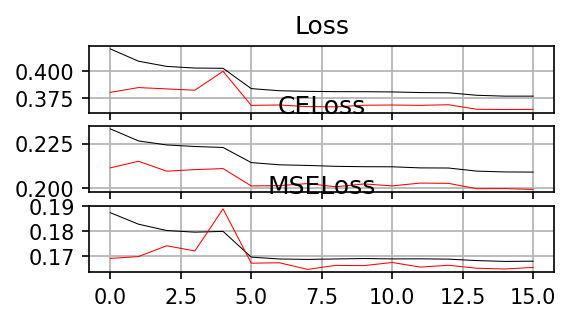

Epoch 16
-------------------------------
loss: 0.469152, ln(1+loss): 0.384685 | CEloss: 0.292863, MSEloss: 0.17628836631774902 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 1.198967, ln(1+loss): 0.787988 | CEloss: 1.045724, MSEloss: 0.1532433182001114 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.299166, ln(1+loss): 0.261723 | CEloss: 0.104126, MSEloss: 0.19503994286060333 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.552198, ln(1+loss): 0.439672 | CEloss: 0.295210, MSEloss: 0.2569878399372101 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.424568, ln(1+loss): 0.353869 | CEloss: 0.252792, MSEloss: 0.17177610099315643 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.391562, ln(1+loss): 0.330427 | CEloss: 0.166924, MSEloss: 0.22463729977607727 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.444465, ln(1+loss): 0.367739 | CEloss: 0.241778, MSEloss: 0.20268762111663818 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 

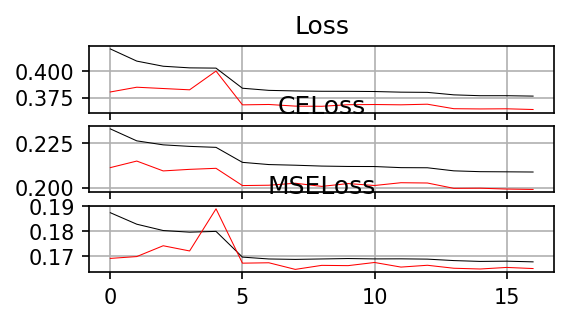

Epoch 17
-------------------------------
loss: 0.227266, ln(1+loss): 0.204789 | CEloss: 0.062608, MSEloss: 0.16465766727924347 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.444174, ln(1+loss): 0.367537 | CEloss: 0.304308, MSEloss: 0.1398659199476242 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.257814, ln(1+loss): 0.229375 | CEloss: 0.057129, MSEloss: 0.2006848305463791 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.222096, ln(1+loss): 0.200567 | CEloss: 0.094705, MSEloss: 0.12739090621471405 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.441473, ln(1+loss): 0.365666 | CEloss: 0.267354, MSEloss: 0.17411907017230988 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.374795, ln(1+loss): 0.318305 | CEloss: 0.200029, MSEloss: 0.17476657032966614 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.239363, ln(1+loss): 0.214598 | CEloss: 0.097016, MSEloss: 0.14234735071659088 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 

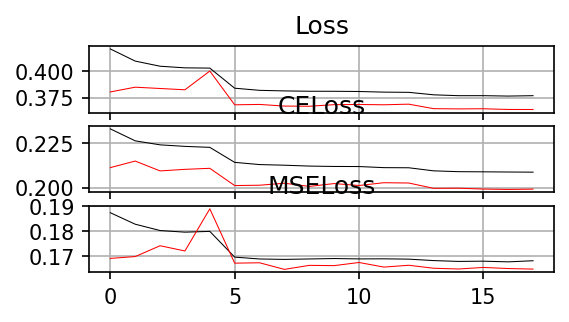

Epoch 18
-------------------------------
loss: 0.227160, ln(1+loss): 0.204703 | CEloss: 0.113493, MSEloss: 0.11366726458072662 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.333692, ln(1+loss): 0.287951 | CEloss: 0.120428, MSEloss: 0.21326376497745514 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.494374, ln(1+loss): 0.401708 | CEloss: 0.236327, MSEloss: 0.25804710388183594 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.531110, ln(1+loss): 0.425993 | CEloss: 0.392999, MSEloss: 0.13811157643795013 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.215675, ln(1+loss): 0.195300 | CEloss: 0.074427, MSEloss: 0.1412487030029297 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.306147, ln(1+loss): 0.267082 | CEloss: 0.107830, MSEloss: 0.19831761717796326 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.984890, ln(1+loss): 0.685563 | CEloss: 0.757677, MSEloss: 0.22721317410469055 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss:

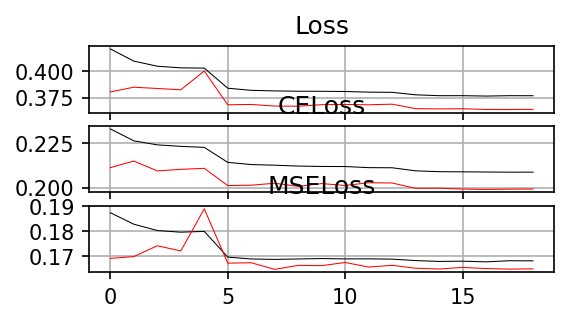

Epoch 19
-------------------------------
loss: 0.274355, ln(1+loss): 0.242440 | CEloss: 0.100398, MSEloss: 0.1739570051431656 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.548428, ln(1+loss): 0.437240 | CEloss: 0.388525, MSEloss: 0.15990322828292847 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.429371, ln(1+loss): 0.357234 | CEloss: 0.286689, MSEloss: 0.14268194139003754 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.158783, ln(1+loss): 0.147370 | CEloss: 0.025358, MSEloss: 0.1334247887134552 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.467079, ln(1+loss): 0.383274 | CEloss: 0.299484, MSEloss: 0.1675957888364792 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.383431, ln(1+loss): 0.324566 | CEloss: 0.198805, MSEloss: 0.1846255213022232 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.206955, ln(1+loss): 0.188101 | CEloss: 0.068883, MSEloss: 0.1380728781223297 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 0.3

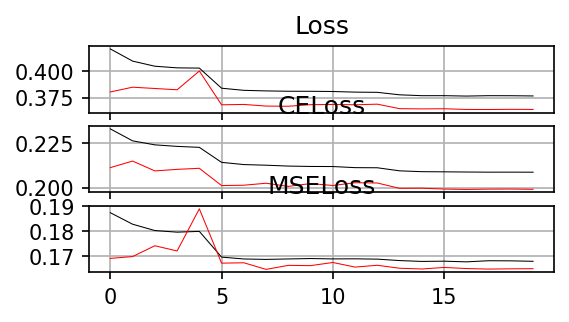

Epoch 20
-------------------------------
loss: 0.628910, ln(1+loss): 0.487911 | CEloss: 0.442337, MSEloss: 0.18657314777374268 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.355149, ln(1+loss): 0.303911 | CEloss: 0.181437, MSEloss: 0.17371158301830292 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.357501, ln(1+loss): 0.305645 | CEloss: 0.157420, MSEloss: 0.20008082687854767 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.378961, ln(1+loss): 0.321331 | CEloss: 0.236263, MSEloss: 0.1426980346441269 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.170449, ln(1+loss): 0.157388 | CEloss: 0.062941, MSEloss: 0.1075085699558258 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.619207, ln(1+loss): 0.481936 | CEloss: 0.525552, MSEloss: 0.09365501999855042 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.518562, ln(1+loss): 0.417764 | CEloss: 0.315455, MSEloss: 0.20310738682746887 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 

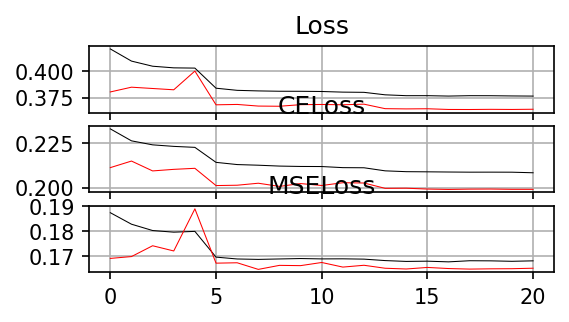

Epoch 21
-------------------------------
loss: 0.305759, ln(1+loss): 0.266784 | CEloss: 0.048795, MSEloss: 0.2569635808467865 | batch: 0 | sample: [    0/45675] | lr: 0.0001
loss: 0.319484, ln(1+loss): 0.277241 | CEloss: 0.128380, MSEloss: 0.19110426306724548 | batch: 500 | sample: [ 5000/45675] | lr: 0.0001
loss: 0.218245, ln(1+loss): 0.197411 | CEloss: 0.087253, MSEloss: 0.1309925764799118 | batch: 1000 | sample: [10000/45675] | lr: 0.0001
loss: 0.170806, ln(1+loss): 0.157692 | CEloss: 0.046308, MSEloss: 0.12449755519628525 | batch: 1500 | sample: [15000/45675] | lr: 0.0001
loss: 0.327372, ln(1+loss): 0.283201 | CEloss: 0.095693, MSEloss: 0.23167921602725983 | batch: 2000 | sample: [20000/45675] | lr: 0.0001
loss: 0.353092, ln(1+loss): 0.302393 | CEloss: 0.213463, MSEloss: 0.1396295130252838 | batch: 2500 | sample: [25000/45675] | lr: 0.0001
loss: 0.487996, ln(1+loss): 0.397430 | CEloss: 0.314550, MSEloss: 0.1734451949596405 | batch: 3000 | sample: [30000/45675] | lr: 0.0001
loss: 0.

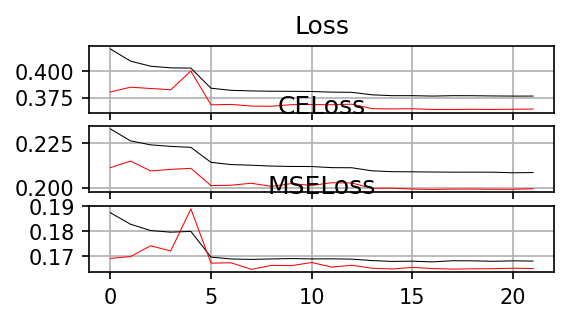

Epoch 22
-------------------------------
loss: 0.330469, ln(1+loss): 0.285531 | CEloss: 0.173750, MSEloss: 0.15671885013580322 | batch: 0 | sample: [    0/45675] | lr: 1e-05
loss: 0.318222, ln(1+loss): 0.276284 | CEloss: 0.171266, MSEloss: 0.14695589244365692 | batch: 500 | sample: [ 5000/45675] | lr: 1e-05
loss: 0.395167, ln(1+loss): 0.333014 | CEloss: 0.268106, MSEloss: 0.1270611733198166 | batch: 1000 | sample: [10000/45675] | lr: 1e-05
loss: 0.471711, ln(1+loss): 0.386425 | CEloss: 0.233243, MSEloss: 0.23846778273582458 | batch: 1500 | sample: [15000/45675] | lr: 1e-05
loss: 0.543555, ln(1+loss): 0.434088 | CEloss: 0.389635, MSEloss: 0.1539197713136673 | batch: 2000 | sample: [20000/45675] | lr: 1e-05
loss: 0.361851, ln(1+loss): 0.308844 | CEloss: 0.223608, MSEloss: 0.13824282586574554 | batch: 2500 | sample: [25000/45675] | lr: 1e-05
loss: 0.847110, ln(1+loss): 0.613622 | CEloss: 0.587186, MSEloss: 0.25992393493652344 | batch: 3000 | sample: [30000/45675] | lr: 1e-05
loss: 0.56448

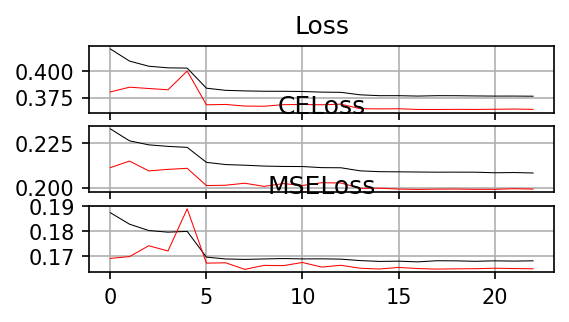

Epoch 23
-------------------------------
loss: 0.235895, ln(1+loss): 0.211796 | CEloss: 0.061830, MSEloss: 0.17406566441059113 | batch: 0 | sample: [    0/45675] | lr: 1e-05
loss: 0.200390, ln(1+loss): 0.182647 | CEloss: 0.048073, MSEloss: 0.15231701731681824 | batch: 500 | sample: [ 5000/45675] | lr: 1e-05
loss: 0.267750, ln(1+loss): 0.237244 | CEloss: 0.089555, MSEloss: 0.17819540202617645 | batch: 1000 | sample: [10000/45675] | lr: 1e-05
loss: 0.384108, ln(1+loss): 0.325056 | CEloss: 0.279137, MSEloss: 0.10497084259986877 | batch: 1500 | sample: [15000/45675] | lr: 1e-05
loss: 0.290695, ln(1+loss): 0.255180 | CEloss: 0.136804, MSEloss: 0.15389102697372437 | batch: 2000 | sample: [20000/45675] | lr: 1e-05
loss: 0.294192, ln(1+loss): 0.257887 | CEloss: 0.159048, MSEloss: 0.13514399528503418 | batch: 2500 | sample: [25000/45675] | lr: 1e-05
loss: 0.428990, ln(1+loss): 0.356968 | CEloss: 0.273513, MSEloss: 0.15547741949558258 | batch: 3000 | sample: [30000/45675] | lr: 1e-05
loss: 0.256

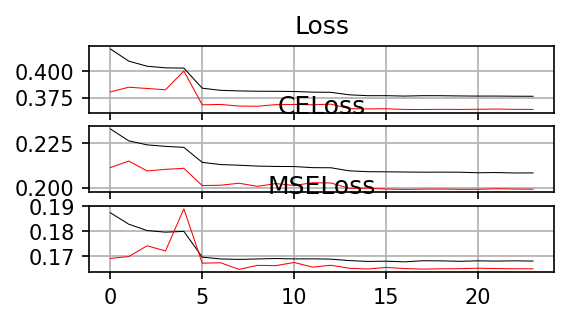

Epoch 24
-------------------------------
loss: 0.282245, ln(1+loss): 0.248612 | CEloss: 0.177085, MSEloss: 0.1051599532365799 | batch: 0 | sample: [    0/45675] | lr: 1e-05
loss: 0.186150, ln(1+loss): 0.170713 | CEloss: 0.062199, MSEloss: 0.12395119667053223 | batch: 500 | sample: [ 5000/45675] | lr: 1e-05
loss: 0.234664, ln(1+loss): 0.210799 | CEloss: 0.094468, MSEloss: 0.14019571244716644 | batch: 1000 | sample: [10000/45675] | lr: 1e-05
loss: 0.174621, ln(1+loss): 0.160946 | CEloss: 0.060799, MSEloss: 0.11382228136062622 | batch: 1500 | sample: [15000/45675] | lr: 1e-05
loss: 0.371861, ln(1+loss): 0.316169 | CEloss: 0.163935, MSEloss: 0.207925945520401 | batch: 2000 | sample: [20000/45675] | lr: 1e-05
loss: 0.507244, ln(1+loss): 0.410283 | CEloss: 0.380906, MSEloss: 0.12633855640888214 | batch: 2500 | sample: [25000/45675] | lr: 1e-05
loss: 0.291874, ln(1+loss): 0.256094 | CEloss: 0.187430, MSEloss: 0.10444436967372894 | batch: 3000 | sample: [30000/45675] | lr: 1e-05
loss: 0.200423

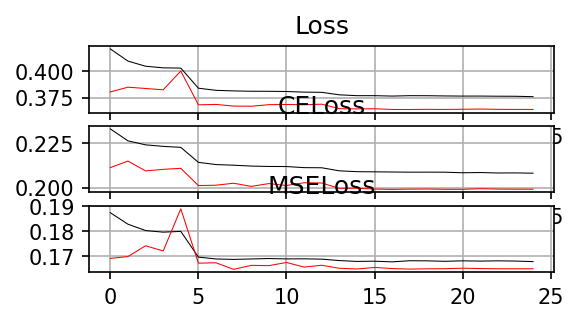

Epoch 25
-------------------------------
loss: 0.240940, ln(1+loss): 0.215869 | CEloss: 0.065763, MSEloss: 0.17517679929733276 | batch: 0 | sample: [    0/45675] | lr: 1e-05
loss: 0.302493, ln(1+loss): 0.264280 | CEloss: 0.075657, MSEloss: 0.22683651745319366 | batch: 500 | sample: [ 5000/45675] | lr: 1e-05
loss: 0.378946, ln(1+loss): 0.321320 | CEloss: 0.110532, MSEloss: 0.2684144675731659 | batch: 1000 | sample: [10000/45675] | lr: 1e-05
loss: 0.197507, ln(1+loss): 0.180242 | CEloss: 0.087487, MSEloss: 0.11002038419246674 | batch: 1500 | sample: [15000/45675] | lr: 1e-05
loss: 0.580519, ln(1+loss): 0.457753 | CEloss: 0.423718, MSEloss: 0.1568015217781067 | batch: 2000 | sample: [20000/45675] | lr: 1e-05
loss: 0.268526, ln(1+loss): 0.237856 | CEloss: 0.109448, MSEloss: 0.15907752513885498 | batch: 2500 | sample: [25000/45675] | lr: 1e-05
loss: 0.238185, ln(1+loss): 0.213646 | CEloss: 0.049273, MSEloss: 0.1889112889766693 | batch: 3000 | sample: [30000/45675] | lr: 1e-05
loss: 0.687786

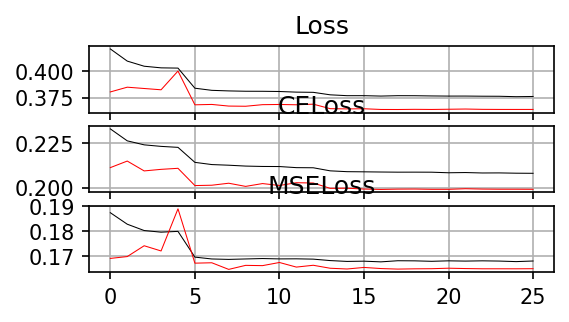

Epoch 26
-------------------------------
loss: 0.238420, ln(1+loss): 0.213837 | CEloss: 0.051597, MSEloss: 0.186823308467865 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-06
loss: 0.249928, ln(1+loss): 0.223086 | CEloss: 0.100064, MSEloss: 0.14986427128314972 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-06
loss: 0.304273, ln(1+loss): 0.265646 | CEloss: 0.129816, MSEloss: 0.1744569092988968 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-06
loss: 0.171951, ln(1+loss): 0.158670 | CEloss: 0.043014, MSEloss: 0.12893718481063843 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-06
loss: 0.270448, ln(1+loss): 0.239370 | CEloss: 0.144021, MSEloss: 0.12642700970172882 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-06
loss: 0.607234, ln(1+loss): 0.474515 | CEloss: 0.419984, MSEloss: 0.18725067377090454 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-06
loss: 0.446403, ln(1+loss): 0.369080 | CEloss: 0

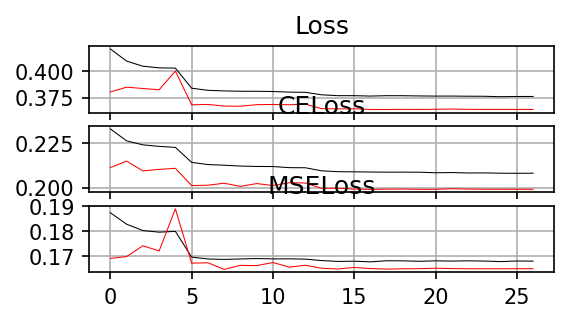

Epoch 27
-------------------------------
loss: 0.348214, ln(1+loss): 0.298781 | CEloss: 0.123116, MSEloss: 0.2250981479883194 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-06
loss: 0.237722, ln(1+loss): 0.213273 | CEloss: 0.048190, MSEloss: 0.18953213095664978 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-06
loss: 0.469675, ln(1+loss): 0.385042 | CEloss: 0.280918, MSEloss: 0.18875755369663239 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-06
loss: 0.174776, ln(1+loss): 0.161078 | CEloss: 0.071629, MSEloss: 0.1031469851732254 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-06
loss: 0.599310, ln(1+loss): 0.469572 | CEloss: 0.432771, MSEloss: 0.1665395349264145 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-06
loss: 0.537797, ln(1+loss): 0.430351 | CEloss: 0.357028, MSEloss: 0.18076898157596588 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-06
loss: 0.231172, ln(1+loss): 0.207967 | CEloss: 0

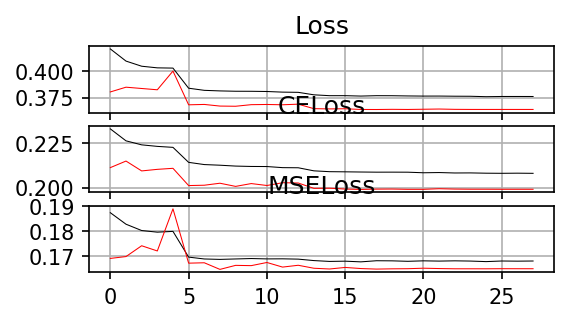

Epoch 28
-------------------------------
loss: 0.319261, ln(1+loss): 0.277072 | CEloss: 0.127484, MSEloss: 0.19177758693695068 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-06
loss: 0.255494, ln(1+loss): 0.227529 | CEloss: 0.109653, MSEloss: 0.14584143459796906 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-06
loss: 0.569987, ln(1+loss): 0.451067 | CEloss: 0.409146, MSEloss: 0.1608412116765976 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-06
loss: 0.443991, ln(1+loss): 0.367411 | CEloss: 0.288491, MSEloss: 0.15549974143505096 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-06
loss: 0.313440, ln(1+loss): 0.272650 | CEloss: 0.183419, MSEloss: 0.13002075254917145 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-06
loss: 0.672213, ln(1+loss): 0.514148 | CEloss: 0.515299, MSEloss: 0.1569136679172516 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-06
loss: 0.553544, ln(1+loss): 0.440539 | CEloss: 

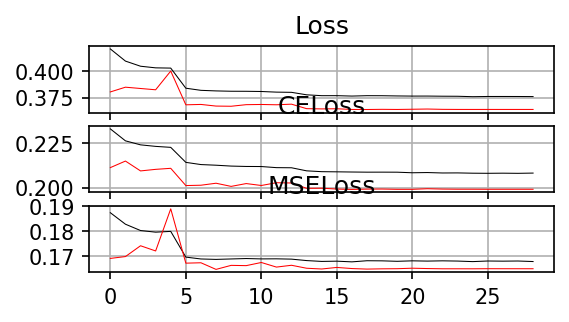

Epoch 29
-------------------------------
loss: 0.343827, ln(1+loss): 0.295522 | CEloss: 0.100695, MSEloss: 0.24313180148601532 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-06
loss: 0.204763, ln(1+loss): 0.186283 | CEloss: 0.056175, MSEloss: 0.14858831465244293 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-06
loss: 0.277923, ln(1+loss): 0.245236 | CEloss: 0.083549, MSEloss: 0.19437400996685028 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-06
loss: 0.502684, ln(1+loss): 0.407253 | CEloss: 0.359585, MSEloss: 0.1430990993976593 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-06
loss: 0.340666, ln(1+loss): 0.293166 | CEloss: 0.220761, MSEloss: 0.11990494281053543 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-06
loss: 0.286901, ln(1+loss): 0.252237 | CEloss: 0.152287, MSEloss: 0.13461308181285858 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-06
loss: 0.264308, ln(1+loss): 0.234525 | CEloss:

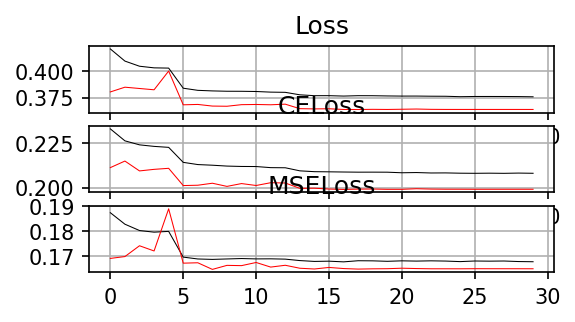

Epoch 30
-------------------------------
loss: 0.332018, ln(1+loss): 0.286695 | CEloss: 0.085415, MSEloss: 0.24660292267799377 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-07
loss: 0.415825, ln(1+loss): 0.347712 | CEloss: 0.195222, MSEloss: 0.22060251235961914 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-07
loss: 0.293299, ln(1+loss): 0.257197 | CEloss: 0.107984, MSEloss: 0.18531501293182373 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-07
loss: 0.309071, ln(1+loss): 0.269318 | CEloss: 0.138731, MSEloss: 0.17034034430980682 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-07
loss: 0.227201, ln(1+loss): 0.204736 | CEloss: 0.054157, MSEloss: 0.1730441302061081 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-07
loss: 1.004009, ln(1+loss): 0.695150 | CEloss: 0.812384, MSEloss: 0.19162584841251373 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-07
loss: 0.265834, ln(1+loss): 0.235731 | CEloss:

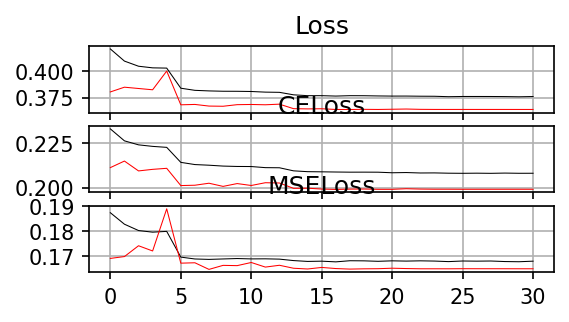

Epoch 31
-------------------------------
loss: 0.225452, ln(1+loss): 0.203310 | CEloss: 0.061831, MSEloss: 0.1636207103729248 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-07
loss: 0.477394, ln(1+loss): 0.390279 | CEloss: 0.301577, MSEloss: 0.1758163571357727 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-07
loss: 0.393931, ln(1+loss): 0.332128 | CEloss: 0.247912, MSEloss: 0.14601951837539673 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-07
loss: 0.312523, ln(1+loss): 0.271952 | CEloss: 0.132382, MSEloss: 0.18014149367809296 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-07
loss: 0.478491, ln(1+loss): 0.391022 | CEloss: 0.351612, MSEloss: 0.12687820196151733 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-07
loss: 0.273638, ln(1+loss): 0.241877 | CEloss: 0.119223, MSEloss: 0.1544145792722702 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-07
loss: 0.277951, ln(1+loss): 0.245258 | CEloss: 0

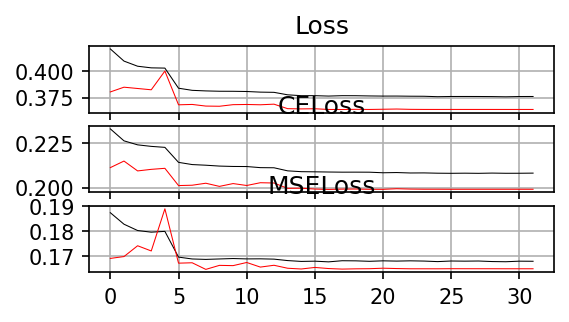

Epoch 32
-------------------------------
loss: 0.172006, ln(1+loss): 0.158717 | CEloss: 0.037081, MSEloss: 0.1349245011806488 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-07
loss: 0.665442, ln(1+loss): 0.510091 | CEloss: 0.483139, MSEloss: 0.18230260908603668 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-07
loss: 0.192487, ln(1+loss): 0.176041 | CEloss: 0.045241, MSEloss: 0.14724652469158173 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-07
loss: 0.397391, ln(1+loss): 0.334607 | CEloss: 0.271399, MSEloss: 0.1259918212890625 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-07
loss: 1.106470, ln(1+loss): 0.745013 | CEloss: 0.940079, MSEloss: 0.1663908213376999 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-07
loss: 0.255101, ln(1+loss): 0.227216 | CEloss: 0.105090, MSEloss: 0.15001147985458374 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-07
loss: 0.257214, ln(1+loss): 0.228898 | CEloss: 0

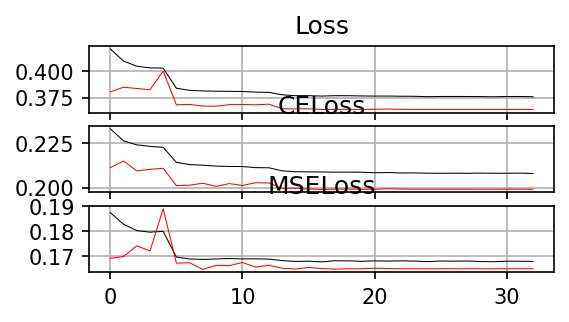

Epoch 33
-------------------------------
loss: 0.528820, ln(1+loss): 0.424496 | CEloss: 0.285666, MSEloss: 0.24315433204174042 | batch: 0 | sample: [    0/45675] | lr: 1.0000000000000002e-07
loss: 0.539986, ln(1+loss): 0.431773 | CEloss: 0.401837, MSEloss: 0.1381487250328064 | batch: 500 | sample: [ 5000/45675] | lr: 1.0000000000000002e-07
loss: 0.476345, ln(1+loss): 0.389569 | CEloss: 0.216995, MSEloss: 0.25934967398643494 | batch: 1000 | sample: [10000/45675] | lr: 1.0000000000000002e-07
loss: 0.312819, ln(1+loss): 0.272177 | CEloss: 0.148604, MSEloss: 0.16421455144882202 | batch: 1500 | sample: [15000/45675] | lr: 1.0000000000000002e-07
loss: 0.240674, ln(1+loss): 0.215655 | CEloss: 0.082249, MSEloss: 0.15842470526695251 | batch: 2000 | sample: [20000/45675] | lr: 1.0000000000000002e-07
loss: 0.298242, ln(1+loss): 0.261011 | CEloss: 0.075906, MSEloss: 0.22233575582504272 | batch: 2500 | sample: [25000/45675] | lr: 1.0000000000000002e-07
loss: 0.301408, ln(1+loss): 0.263447 | CEloss:

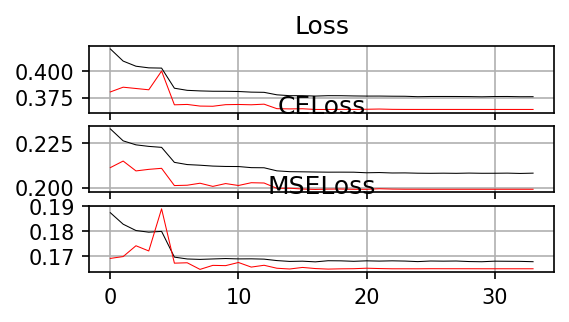

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Predicted ------------------------------------------------------------------------------------------
Actual    ------------------------------------------------------------------------------------------

pppdpddddpddddpdddddppppxppppppdxxxxssppddppdpxpdddpdppxxssxssspdppppppsxxxxdpxsxpddppssdddppxppxxxx
_ppppp_pp_p_p_ppppdppp_pppppppppppdx_p_p_ppppp_pp_ppppppp_pps_ppppppp_xppd_ppdx_pppp_p_ppdppppppdppx

sxxxpppppppppdddxddpdppppxsxxxdxxpddppppddpppxxxdpppppxpppppdppxxxxsxxxssxxxssssssxsdpddddddddpppppp
_d_pppp_p_pppp_pppppppppdxppp_p_pppppppppppppd_ppppppppp_ppppppppdx_dpsx_dppdx_xxp_p_pppppppd_p_pppp

ppdppppddppppxxxxxdpppddddsppppppdpddpppppppddpdppppddpxxxxddppppsssdddppxppppddpppxxxxpddddppxpxppd
_dpppppppppppppd_p_p_p_ppd_pppp_p_ppp_p_ppppdpppppppppppds_dpppppp_pppp_pppppdpppppppp_ppp_ppp_pp_pp

ddpppxdpppppxsxsxdpdppxppddxdddppddppssppppppppdddddddppppppdddpddpppdxddddddppppxpppppppppppxpppdds
dpp_pdppppppxsx_ppdppd_pppp_pdp_pdppp_p_p_p_pppppppppp_ppp_ppp_ppppppp_pppppppppppppppp

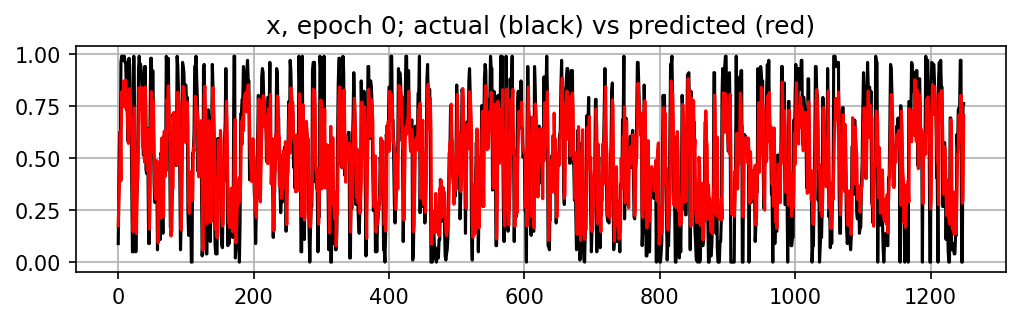

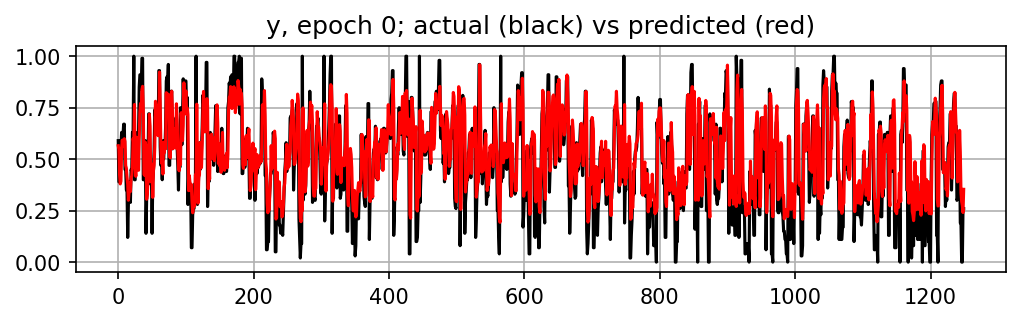

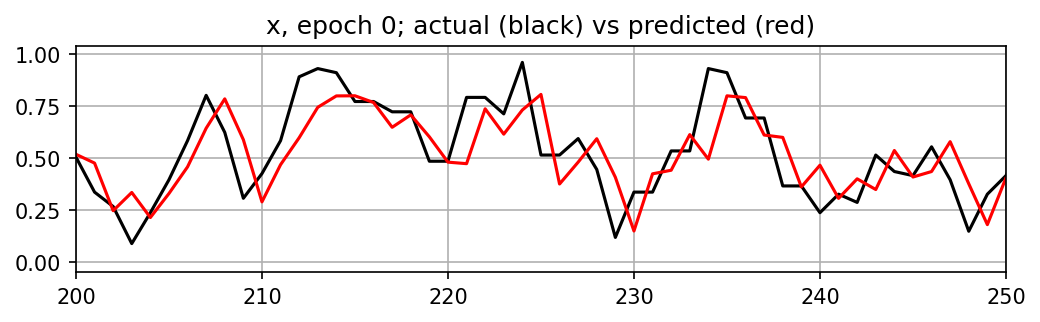

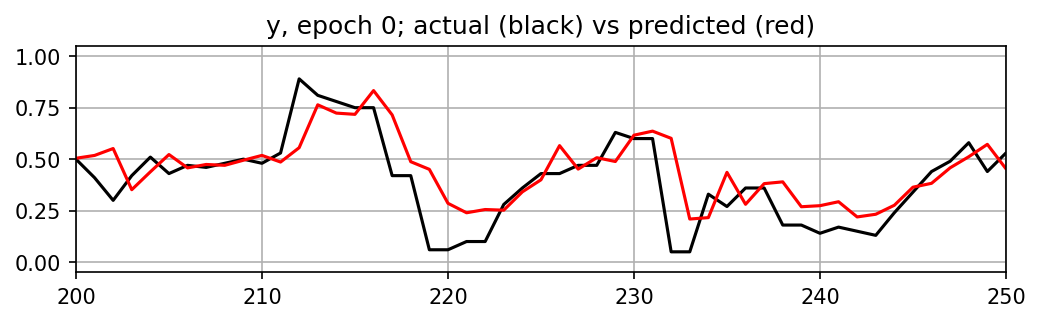

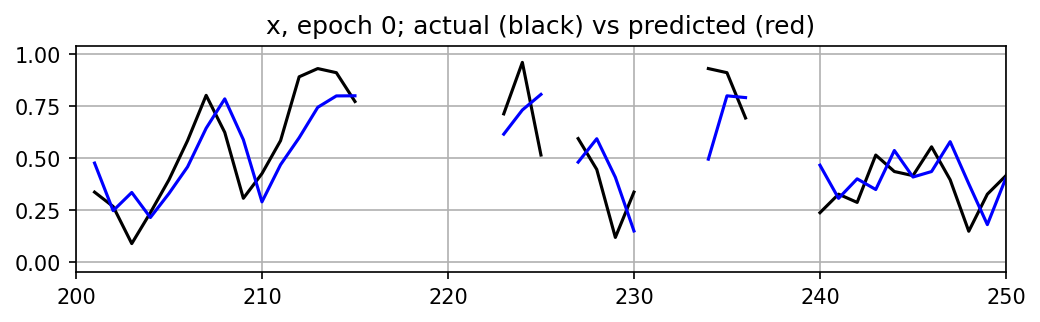

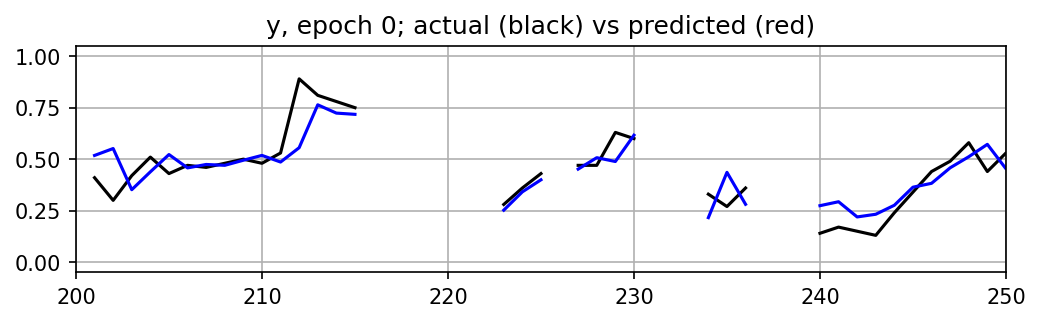

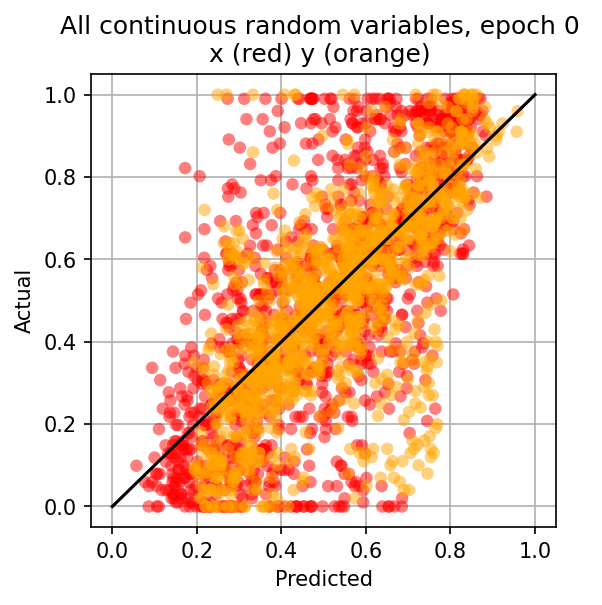

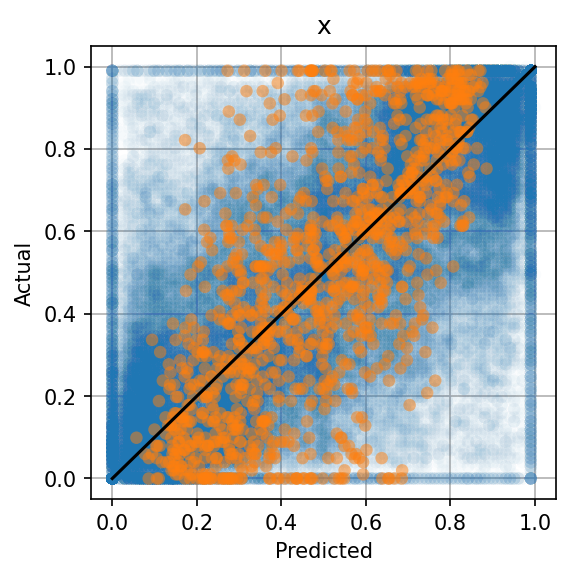

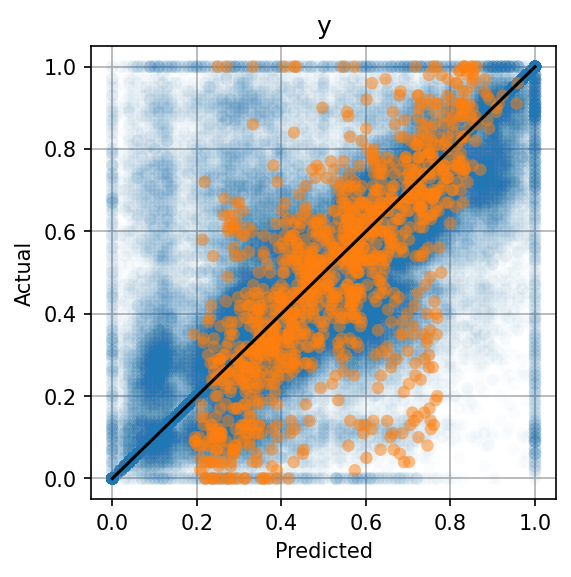

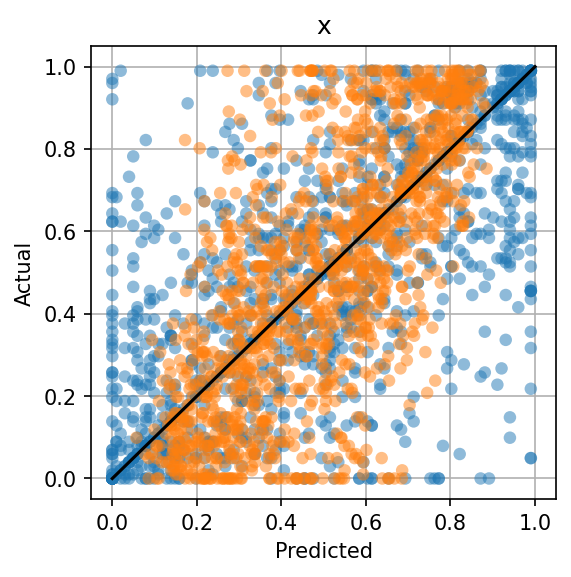

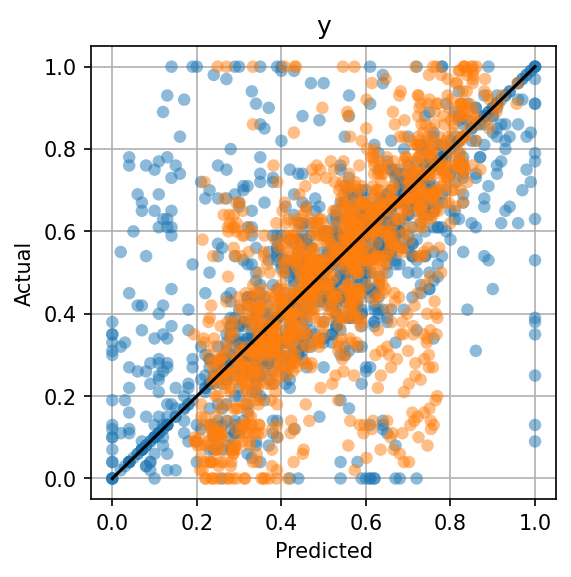

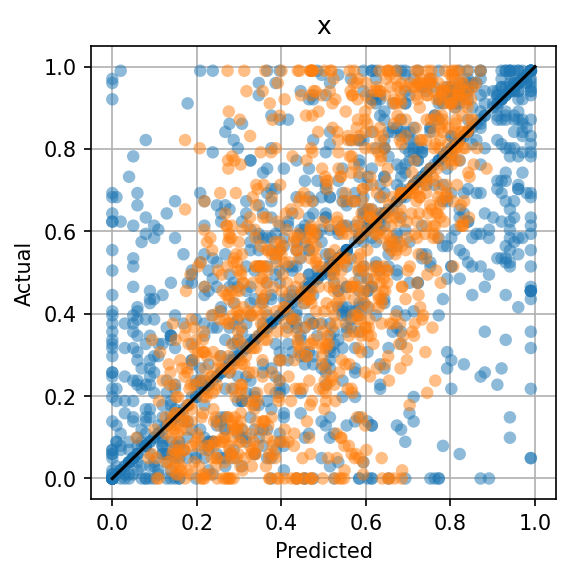

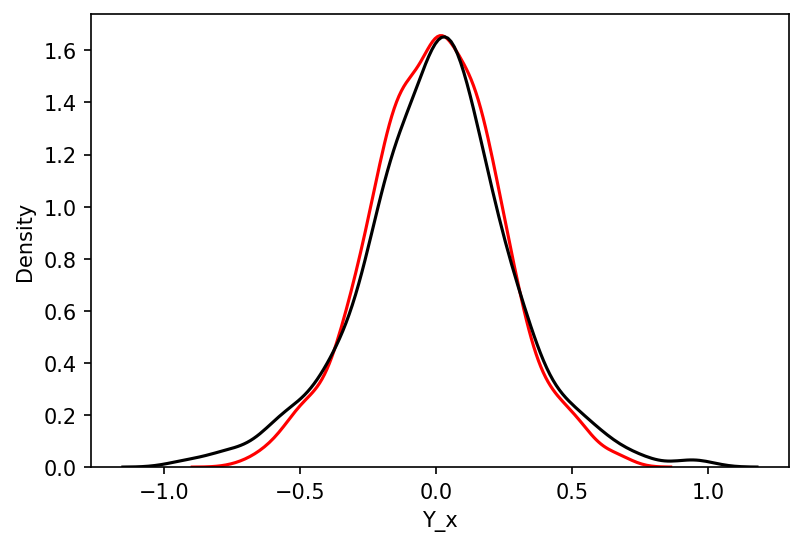

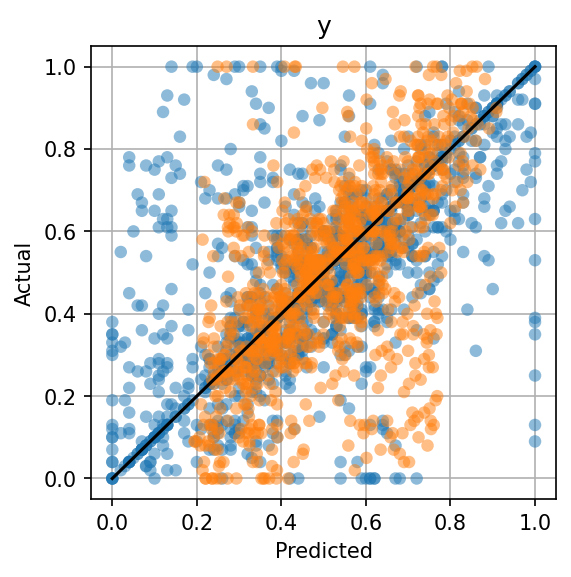

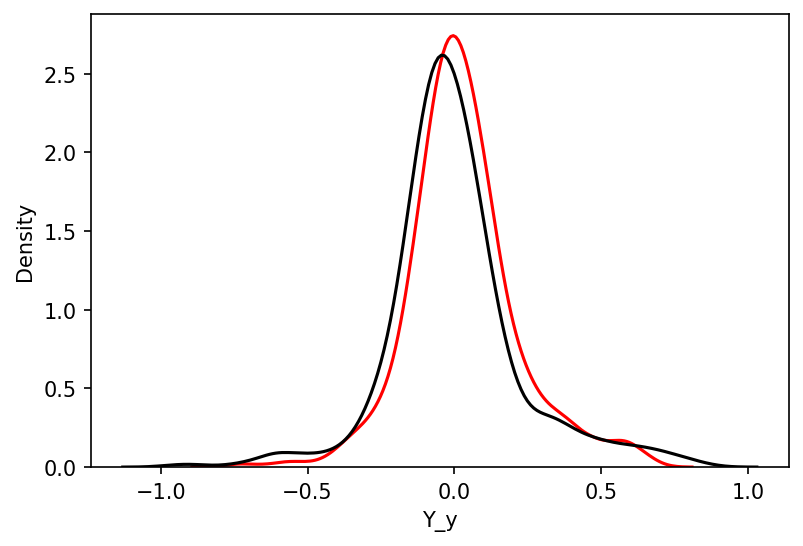

Calculating test loss
loss: 0.270318, ln(1+loss): 0.239267 | CEloss: 0.138728, MSEloss: 0.1315900981426239 | batch: 0 | sample: [    0/45794] | lr: 1.0000000000000004e-08
loss: 0.216454, ln(1+loss): 0.195940 | CEloss: 0.044483, MSEloss: 0.17197111248970032 | batch: 500 | sample: [ 5000/45794] | lr: 1.0000000000000004e-08
loss: 0.187118, ln(1+loss): 0.171528 | CEloss: 0.047397, MSEloss: 0.13972003757953644 | batch: 1000 | sample: [10000/45794] | lr: 1.0000000000000004e-08
loss: 0.253530, ln(1+loss): 0.225964 | CEloss: 0.086741, MSEloss: 0.16678914427757263 | batch: 1500 | sample: [15000/45794] | lr: 1.0000000000000004e-08
loss: 0.258928, ln(1+loss): 0.230260 | CEloss: 0.079462, MSEloss: 0.17946626245975494 | batch: 2000 | sample: [20000/45794] | lr: 1.0000000000000004e-08
loss: 0.424686, ln(1+loss): 0.353952 | CEloss: 0.271864, MSEloss: 0.15282244980335236 | batch: 2500 | sample: [25000/45794] | lr: 1.0000000000000004e-08
loss: 1.200619, ln(1+loss): 0.788739 | CEloss: 1.073177, MSEloss:

In [259]:
##########################################################################################
# 11) TRAIN! specifically for just Trf-31
##########################################################################################
num_action_cats = num_chars
act_padding_idx = 1
scale_grad_by_freq = True
num_contvars_in  = len(input_vars) - 1
num_contvars_out = len(target_vars) - 1
transformer_finaldenselayer_dim = 64

cat_embedding_dim = 7
cont_embedding_dim = 10
num_layers = 1
dim_feedforward = 8
model_type = "Transformer"
transformer_nhead = 1

from datetime import datetime
all_loss = np.empty((0,14))


d_model = cat_embedding_dim + cont_embedding_dim
final_loss = go()
config = np.array([cat_embedding_dim,cont_embedding_dim,num_layers,dim_feedforward,model_type])
all_loss = np.vstack((all_loss,np.hstack((config,final_loss))))
date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
np.savetxt(f"/content/gdrive/MyDrive/SEQ2Event_github/NB2_Outputs_v202208/model_res_{date}.csv",all_loss,delimiter=",",fmt='%s')

# Apply Trained Model to Gain Insights into Wider Dataset

**TID Lookup (for convenience)**

675  Real Madrid

676  FC Barcelona

679  Atletico Madrid

683  Malaga

756  Girona FC

Downloading...
From: https://drive.google.com/uc?id=1-QPhkhFGJCjL_Bc_zIGCYkLGsB7TZAPu
To: /content/WyScout_open_data_df_notebook1_step2.pkl
100% 293M/293M [00:01<00:00, 292MB/s]


100%|██████████| 189/189 [00:12<00:00, 15.18it/s]


n idx_all 139127


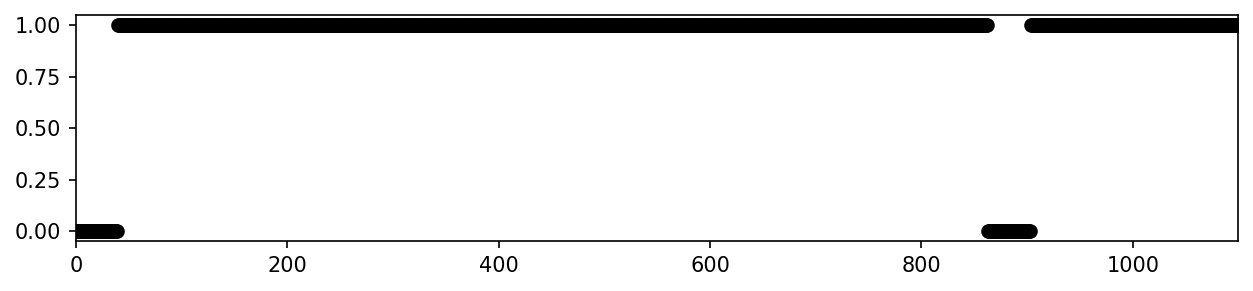

132157
{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}


In [260]:
##########################################################################################
# 10) Stages 0-3 above, to generate a fresh dataset on which we wish to apply the trained model
##########################################################################################
#future dev: streamline this so this happens at the start

################################################################################################
# 0a) Download data from step 1 "data import" notebook
################################################################################################
!gdown 1-QPhkhFGJCjL_Bc_zIGCYkLGsB7TZAPu    #Google Drive open access sharing link
df = pd.read_pickle("/content/WyScout_open_data_df_notebook1_step2.pkl")
df = df.reset_index()

################################################################################################
# 1b) filter dataframe: keep only matches of the teams of interest [simplified version]
################################################################################################
idx = np.isin(df["TID"],[675,676,679,683,756])

################################################################################################
# 1d) filter dataframe further now we have chosen the matches we want
################################################################################################
df = df.loc[idx,:]
df = df.sort_values(by=['TID','MID','index'])
df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

################################################################################################
# 2a) make a generic buffer row (we'll need to update the '123' fields however before adding in the for loop)
################################################################################################
paddingrow = df.iloc[-1,:]
paddingrow = pd.DataFrame(paddingrow).T
paddingrow["comp"] = "na"       #need to update each time padding is added
paddingrow["TID"] = 123         #need to update each time padding is added
paddingrow["MID"] = 123         #need to update each time padding is added
paddingrow["index"] = 1000000000
paddingrow["PID"] = 1000000000
paddingrow["act"] = "@"
paddingrow["T"] = 0.5           #df["T"].mean()
paddingrow["deltaT"] = 0.5      #df["deltaT"].mean()
paddingrow["x"] = 0.5          #df["x"].mean()
paddingrow["y"] = 0.5          #df["y"].mean()
paddingrow["s"] = 0.2           #df["s"].mean() 
paddingrow["scrad"] = 0.5       #df["scrad"].mean()
paddingrow["deltax"] = 0.5     #df["deltax"].mean() 
paddingrow["deltay"] = 0.5     #df["deltay"].mean()
paddingrow["sg"] = 0.57         #df["sg"].mean()
paddingrow["thetag"] = 0.74     #df["thetag"].mean()
num_paddingrows=1
paddingrows = paddingrow.iloc[np.repeat(0,num_paddingrows),:]

################################################################################################
# 2b) make a generic buffer row (we'll need to update the '123' fields however before adding in the for loop)
################################################################################################
def insert_rows(idx, df, df_to_insert):  # convenience function to insert a row
    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]
    df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
    return df

################################################################################################
# 2c) find out where we need to insert this padding/buffers
################################################################################################
bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #the idxn indicates the LAST row of a match (MID)

################################################################################################
# 2d) insert the buffers
################################################################################################
for i in tqdm(range(0,len(bufidxns))):   # insert the padding/buffers
  # print(i)
  bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #recompute each time...
  bufidxn = bufidxns[i]
  paddingrows["comp"] = df.loc[bufidxn,"comp"]
  paddingrows["TID"] = df.loc[bufidxn,"TID"]
  paddingrows["MID"] = df.loc[bufidxn,"MID"]
  df = insert_rows(bufidxn+1,df,paddingrows)

df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

##########################################################################################
# 2e) minor tidy-up: rearrange columns
##########################################################################################
df = df.loc[:,['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']]

##########################################################################################
# 3a)i)   whole set -> idx_all (100% of total)
##########################################################################################
idx_all = np.repeat(True,len(df))
print("n idx_all",np.sum(idx_all))

##########################################################################################
# 3b)i) Hyperparameters
##########################################################################################
maxlen = 40
step = 1

##########################################################################################
# 3b)ii) Define valid slices
##########################################################################################
df["valid_slice_flag"]=False
matches = np.unique(df["MID"])
for m in matches:
  #print(m)
  idx = df["MID"] == m
  idxn = np.where(idx)[0]
  df.loc[idxn[maxlen::step],"valid_slice_flag"] = True     #the first slice will be start at "maxlen" into match; and then be offset by "step" until end of match
  df.loc[idxn[-1],"valid_slice_flag"] = False              #exclude the final row, which is the sample corresponding to EOM "@" action

fig, ax = plt.subplots(figsize=(10,2))
ax.scatter(range(len(df)),df["valid_slice_flag"],color="black")
ax.set_xlim(0,1100)
plt.show()
print(np.sum(df["valid_slice_flag"]))

##########################################################################################
# 3c)i)   Define dataset class
##########################################################################################
class SoccerDataset(Dataset):
    # cut the text in semi-redundant sequences of maxlen characters
    def __init__(self,idx=idx_all):
        self.idx = idx
        self.valid_slice_idxn = np.where(np.logical_and(self.idx,df["valid_slice_flag"]))[0]  #in both the idx and has a valid slice flag
    def __len__(self):
        return int(np.sum(df.loc[self.idx,"valid_slice_flag"]))
    def __getitem__(self, i):
        j = self.valid_slice_idxn[i]
        y = df.iloc[j].loc[target_vars]
        x = df.iloc[(j-maxlen):j].loc[:,input_vars]
        return x.to_numpy(), y.to_numpy().astype(float)


##########################################################################################
# 3c)ii)  Define datasets
##########################################################################################
# define datasets
all_dataset = SoccerDataset()

##########################################################################################
# 3c)iii) Define dataloaders
##########################################################################################
batch_size, num_workers = 10, 1
all_loader = DataLoader(all_dataset,shuffle=False,batch_size=batch_size,num_workers=1,drop_last=False)

##########################################################################################
# 4) Define categorical action encode/decode
##########################################################################################
# replace own goal "h" with goal "g" (rare instance... simplest solution for this version... to do 'properly' in future development...)
idx = df["act"] == "h"
df.loc[idx,"act"] = "g"

# set up idx2char and char2idx
chars = sorted(list(set(df['act'])))     # list of all unique characters in the text
num_chars_test = len(chars)                   
char2idx_test = dict((c, i) for i, c in enumerate(chars))
idx2char_test = dict((i, c) for i, c in enumerate(chars))

num_chars=7 # hyperparameter
idx2char = {0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
char2idx = {'@': 0, '_': 1, 'd': 2, 'g': 3, 'p': 4, 's': 5, 'x': 6}

# let's just check that our hard coded values match what's in the data at this point...
assert num_chars_test == num_chars
assert idx2char_test == idx2char
assert char2idx_test == char2idx

# replace characters with numbers
df['act'].replace(char2idx,inplace=True)
print(idx2char)

In [261]:
##########################################################################################
# 10) Use trained model to make predictions on whole set (idx_all)
##########################################################################################

##########################################################################################
# 10a) Load previous model state, if appropriate
##########################################################################################
#If starting point is here.. load previously trained model state...
model = Soccer_Model_3ze().to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/SEQ2Event_github/NB2_Outputs_v202208/MDLstate_2022_08_08-210653"))
#dissertation model Trf-31 state: model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_2021_08_25-205146_CONFIG-Trf-31"))

##########################################################################################
# 10b) Specify dataset we wish to apply the model to
##########################################################################################
dataloader = all_loader

##########################################################################################
# 10c) Apply model
##########################################################################################
model.eval()                     #turn training off if not already
i = 0
for batch, (X, Y) in enumerate(tqdm(dataloader)):
    X = X.to(device)
    pred = model(X)
    if i == 0:
      all_pred = pred.detach().cpu()
    else:
      all_pred = torch.cat((all_pred,pred.detach().cpu()))
    i+=1

all_pred = all_pred.numpy()
date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
np.save(f"/content/gdrive/MyDrive/SEQ2Event_github/NB2_Outputs_v202208/all_pred_{date}.npy", all_pred)
print(all_pred.shape)

Soccer_Model_3ze(
  (emb): Embedding(7, 7, padding_idx=1, scale_grad_by_freq=True)
  (lin0): Linear(in_features=10, out_features=10, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
    )
    (linear1): Linear(in_features=17, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=17, bias=True)
    (norm1): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (seqnet): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
        )
        (linear1): Linear(in_

100%|██████████| 13216/13216 [05:38<00:00, 38.99it/s]


(132157, 9)


In [ ]:
all_pred = np.load("/content/gdrive/MyDrive/SEQ2Event_github/NB2_Outputs_v202208/all_pred_2022_08_09-210901.npy")

##########################################################################################
# 10b) Append predictions to original data
##########################################################################################

##########################################################################################
# 10b)i)   Make dfpred from df: a dataframe to store predictions alongside actuals
##########################################################################################
dfpred = df.copy(deep=True)
dfpred = dfpred.reset_index()
dfpred["act"] = [idx2char[number] for number in dfpred["act"]]

print(dfpred.shape, all_pred.shape,np.sum(dfpred["valid_slice_flag"]))
#all_pred length is same as number of valid slice flags... as it's only produced for valid slices. We need to bear this in mind when combining.

##########################################################################################
# 10b)ii)  Prepare dfpred
##########################################################################################
#prepare dfpred
colnames = list(idx2char.values())   #make column names - 7 actions followed by x, y
colnames.extend(["action","pitchx","pitchy"])
colnames = ["pred_"+c for c in colnames]
for c in colnames:
  dfpred[c] = 0.
dfpred["pred_action"] = "@"

##########################################################################################
# 10b)iii)  Remove not valid_slice_flag rows
##########################################################################################
dfpred = dfpred.loc[dfpred["valid_slice_flag"]]

##########################################################################################
# 10b)iv)  Insert valid all_pred
##########################################################################################
from scipy.special import softmax
dfpred.loc[:,colnames[:7]] = softmax(all_pred[:,:7],axis=1)
temp_acts = np.argmax(all_pred[:,:7],axis=1)
dfpred.loc[:,colnames[7]]  = [idx2char[number] for number in temp_acts]
dfpred.loc[:,colnames[8:]] = all_pred[:,7:]
